**TO DO:** <br>
* Enlem ve Boylam çıkartıalrak tekrar denenecek fakat bu notebookta değil kesinlikle! Yeni Notebook açılacak.
* SARIMA ve ARIMA ile modellemeler yapılıp çıktılara bakılacak. Bu yer ve büyüklük kırılımında incelenecek.
* Vector Autoregressive Model (eğer vakit kalırsa) bakılacak.
* Dataset üzerinde çeşitli görselleştirmeler yapılacak. Böylelikle sunum zenginleştirilecek.
* Kendi ürettiğim tahminler üzerinde de görselleştirmeler yapılacak.
* SMAPE'yi proya açıklayabilecek seviyede öğren. Daha sonra 5 yaşındaki çocuğa açıklayabilecek şekilde özetle.
* Elimizde **SIĞ** depremler var. Ona göre sunumda eklersin.


# Earthquake

## Setup Enviroments & Load Data

In [115]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable
                                              0.0/404.2 kB ? eta -:--:--
     ----------                             112.6/404.2 kB 3.2 MB/s eta 0:00:01
     -------------------                    204.8/404.2 kB 2.5 MB/s eta 0:00:01
     -------------------------------------  399.4/404.2 kB 3.1 MB/s eta 0:00:01
     -------------------------------------- 404.2/404.2 kB 2.5 MB/s eta 0:00:00
                                              0.0/226.0 kB ? eta -:--:--
     --------------------                   122.9/226.0 kB 3.6 MB/s eta 0:00:01
     -------------------------------------- 226.0/226.0 kB 2.8 MB/s eta 0:00:00
                                              0.0/78.7 kB ? eta -:--:--
     ------------------------------------     71.7/78.7 kB 3.8 MB/s eta 0:00:01
     ---------------------------------------- 78.7/78.7 kB 1.5 MB/s eta 0:00:00


In [300]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
import re
import optuna

In [301]:
pd.set_option("display.max_rows",1000)

In [302]:
# df_ = pd.read_csv("turkey_earthquakes1915-2023_may.csv", encoding="unicode-escape", sep=",",on_bad_lines="skip")
# df2_ = pd.read_csv("veri2.csv", encoding="unicode-escape", sep=";",on_bad_lines="skip")

In [303]:
# df_["Yer"] = df2_["Yer"].copy()

In [304]:
df2_ = pd.read_excel("kaggle_test2.xlsx",index_col="Unnamed: 0")

FileNotFoundError: [Errno 2] No such file or directory: 'kaggle_test.xlsx'

In [305]:
df_ = pd.read_csv("dataset.csv", encoding="unicode-escape", sep=",",on_bad_lines="skip",index_col="Unnamed: 0")

In [306]:
df = df_.copy()

## EDA & Preprocess

In [307]:
df.head()

,No,Deprem Kodu,Olus tarihi,Olus zamani,Enlem,Boylam,Derinlik,xM,MD,ML,Mw,Ms,Mb,Tip,Yer
0,1,20230430130127,2023.04.30,13:01:27.69,38.33920,37.76330,8.70000,4.30000,0.00000,4.30000,4.30000,0.00000,0.00000,Ke,KEPEZ-AKCADAG (MALATYA) [East 1.7 km]
1,2,20230430040253,2023.04.30,04:02:53.49,40.80770,31.07080,3.70000,3.50000,0.00000,3.50000,3.40000,0.00000,0.00000,Ke,PASAKONAGI- (DUZCE) [South West 0.9 km]
2,3,20230430025122,2023.04.30,02:51:22.15,35.64220,34.02520,22.40000,3.50000,0.00000,3.50000,3.50000,0.00000,0.00000,Ke,AKDENIZ
3,4,20230429194832,2023.04.29,19:48:32.87,37.86230,36.21850,5.00000,4.00000,0.00000,3.90000,4.00000,0.00000,0.00000,Ke,KARAKUYU-SAIMBEYLI (ADANA) [East 1.4 km]
4,5,20230429175829,2023.04.29,17:58:29.20,38.02200,36.44570,5.00000,3.70000,0.00000,3.70000,3.40000,0.00000,0.00000,Ke,YIRICEK-GOKSUN (KAHRAMANMARAS) [North West 2....


Her yılda kaç gün var ona bakalım. Az olanları çıkartalım. Zamansal olarak ekisk veri bizi aşırı zorlar. Ayrıca, sahte trendler oluşmasına engel olmamız lazım.

In [308]:
df.columns

Index(['No', 'Deprem Kodu', 'Olus tarihi', 'Olus zamani', 'Enlem', 'Boylam',
       'Derinlik', 'xM', 'MD', 'ML', 'Mw', 'Ms', 'Mb', 'Tip', 'Yer'],
      dtype='object')

In [309]:
# Değişken isimlerini küçültüyorum
df.columns = [col.lower() for col in df.columns]

In [310]:
df.head()

,no,deprem kodu,olus tarihi,olus zamani,enlem,boylam,derinlik,xm,md,ml,mw,ms,mb,tip,yer
0,1,20230430130127,2023.04.30,13:01:27.69,38.33920,37.76330,8.70000,4.30000,0.00000,4.30000,4.30000,0.00000,0.00000,Ke,KEPEZ-AKCADAG (MALATYA) [East 1.7 km]
1,2,20230430040253,2023.04.30,04:02:53.49,40.80770,31.07080,3.70000,3.50000,0.00000,3.50000,3.40000,0.00000,0.00000,Ke,PASAKONAGI- (DUZCE) [South West 0.9 km]
2,3,20230430025122,2023.04.30,02:51:22.15,35.64220,34.02520,22.40000,3.50000,0.00000,3.50000,3.50000,0.00000,0.00000,Ke,AKDENIZ
3,4,20230429194832,2023.04.29,19:48:32.87,37.86230,36.21850,5.00000,4.00000,0.00000,3.90000,4.00000,0.00000,0.00000,Ke,KARAKUYU-SAIMBEYLI (ADANA) [East 1.4 km]
4,5,20230429175829,2023.04.29,17:58:29.20,38.02200,36.44570,5.00000,3.70000,0.00000,3.70000,3.40000,0.00000,0.00000,Ke,YIRICEK-GOKSUN (KAHRAMANMARAS) [North West 2....


In [311]:
df.drop(["md","ml","mw","ms","mb"],axis=1,inplace=True)

In [312]:
df["olus tarihi"] = df["olus tarihi"].astype(str)

In [313]:
df["olus zamani"] = df["olus zamani"].astype(str)

In [314]:
# tip değişkeni 2 sınıf ve SM sınıfından sadece 2 gözlem var. O yüzden dropluyorum bu kolonu.
df["depremin_olus_zamani"] = df["olus tarihi"] + " " + df["olus zamani"]
df.drop(["olus tarihi", "olus zamani", "tip"], axis = 1, inplace = True)

In [315]:
df.head()

,no,deprem kodu,enlem,boylam,derinlik,xm,yer,depremin_olus_zamani
0,1,20230430130127,38.33920,37.76330,8.70000,4.30000,KEPEZ-AKCADAG (MALATYA) [East 1.7 km],2023.04.30 13:01:27.69
1,2,20230430040253,40.80770,31.07080,3.70000,3.50000,PASAKONAGI- (DUZCE) [South West 0.9 km],2023.04.30 04:02:53.49
2,3,20230430025122,35.64220,34.02520,22.40000,3.50000,AKDENIZ,2023.04.30 02:51:22.15
3,4,20230429194832,37.86230,36.21850,5.00000,4.00000,KARAKUYU-SAIMBEYLI (ADANA) [East 1.4 km],2023.04.29 19:48:32.87
4,5,20230429175829,38.02200,36.44570,5.00000,3.70000,YIRICEK-GOKSUN (KAHRAMANMARAS) [North West 2....,2023.04.29 17:58:29.20


In [316]:
df["depremin_olus_zamani"] = pd.to_datetime(df["depremin_olus_zamani"])

In [317]:
df.describe([0.1,0.2,0.5,0.75,0.9,0.95,0.99])

,no,deprem kodu,enlem,boylam,derinlik,xm
count,19908.00000,19908.00000,19908.00000,19908.00000,19908.00000,19908.00000
mean,9954.50000,19988425590863.57031,38.04891,32.44588,14.78335,3.98193
std,5747.08892,203233271249.34875,1.59978,5.83692,20.68979,0.53174
min,1.00000,19150214082000.00000,35.00000,26.00000,0.00000,3.50000
10%,1991.70000,19710917956692.80078,35.80000,26.72294,2.50000,3.50000
20%,3982.40000,19820629045079.39844,36.47532,27.22000,5.00000,3.60000
50%,9954.50000,20031121557818.00000,38.11000,29.75000,8.50000,3.80000
75%,14931.25000,20150222284254.00000,39.12278,37.26000,14.00000,4.20000
90%,17917.30000,20210731202022.10156,40.35000,42.37000,33.00000,4.70000
95%,18912.65000,20230207041330.64844,40.75000,43.57469,57.16500,5.10000


**Gerçekleşen depremlerin sadece %5'i 5.0'dan büyük.**

In [318]:
df.shape, df.no.nunique(), df["deprem kodu"].nunique()

((19908, 8), 19908, 19907)

In [319]:
df.drop_duplicates(subset=["deprem kodu"],inplace = True)
df.shape

(19907, 8)

In [320]:
df["depremin_olus_zamani"].min(), df["depremin_olus_zamani"].max()

(Timestamp('1915-02-14 08:20:00.600000'),
 Timestamp('2023-04-30 13:01:27.690000'))

In [321]:
# Türkçe karakterleri İngilizce karakterlere dönüştüren bir çeviri sözlüğü oluşturalım
turkce_ingilizce_ceviri = {
    'ç': 'c',
    'ğ': 'g',
    'ı': 'i',
    'ö': 'o',
    'ş': 's',
    'ü': 'u',
    'Ç': 'C',
    'Ğ': 'G',
    'İ': 'I',
    'Ö': 'O',
    'Ş': 'S',
    'Ü': 'U'
}


df["yer"] = df["yer"].apply(lambda yer: yer.translate(str.maketrans(turkce_ingilizce_ceviri)))

In [322]:
# Şehir isimlerini çekmek için düzenli ifade kullanalım

def extract_cities(dataframe,column):
  sadece_sehirler = []
  for yer in dataframe[column]:
      eslesme = re.search(r'\((.*?)\)', yer)  # Parantez içindekileri kontrol et
      if eslesme:
          sadece_sehirler.append(eslesme.group(1))  # Parantez içindeki değeri ekle
      else:
          sadece_sehirler.append(yer)  # Parantez içinde değer yoksa doğrudan ekle
  return sadece_sehirler

df["temizlenmis_yer"] = extract_cities(df,"yer")

In [323]:
# Köşeli parantezleri atıyoruz. Böylelikle o şehir/alandaki depremlere odaklanmış oluyoruz.
df["temizlenmis_yer"] = df["temizlenmis_yer"].apply(lambda yer: re.sub(r'\[.*?\]', '', yer))

In [324]:
df.groupby("temizlenmis_yer").agg({"temizlenmis_yer":"count"})

,temizlenmis_yer
temizlenmis_yer,
#NAME?,4
ABAS-EMET KUTAHYA,3
ABIDE-GEDIZ KUTAHYA,2
ADANA,201
ADANA,2
ADIYAMAN,219
AFYONKARAHISAR,320
AFYONKARAHiSAR,1
AGAC-DUMLUPINAR KUTAHYA,1


In [325]:
# Yerin neresi olduğu belli olmadığı için çıkartıyorum.
df = df[~(df["temizlenmis_yer"] == "#NAME?")]

In [326]:
df.isnull().sum()

no                      0
deprem kodu             0
enlem                   0
boylam                  0
derinlik                0
xm                      0
yer                     0
depremin_olus_zamani    0
temizlenmis_yer         0
dtype: int64

In [327]:
df.columns

Index(['no', 'deprem kodu', 'enlem', 'boylam', 'derinlik', 'xm', 'yer',
       'depremin_olus_zamani', 'temizlenmis_yer'],
      dtype='object')

In [328]:
df.shape

(19903, 9)

In [329]:
df.groupby("temizlenmis_yer").agg({"xm":["count","mean","median","std"]}).sort_values(by=("xm","mean"),ascending= False)

xm                        
                                    count    mean  median     std
temizlenmis_yer                                                  
ERZINCAN                                1 6.00000 6.00000     NaN
KUCUKKOY-DOMANIC KUTAHYA                1 5.80000 5.80000     NaN
KONUS-EMET KUTAHYA                      1 5.60000 5.60000     NaN
MURATLI-DOMANIC KUTAHYA                 1 5.60000 5.60000     NaN
YENIKOY-SIMAV KUTAHYA                   1 5.60000 5.60000     NaN
CARSAMBA-DOMANIC KUTAHYA                1 5.50000 5.50000     NaN
ARDAHAN                                 1 5.50000 5.50000     NaN
AKPINAR-CAVDARHISAR KUTAHYA             1 5.50000 5.50000     NaN
KARAKOY-DOMANIC KUTAHYA                 1 5.40000 5.40000     NaN
GUMUSGOLCUK-TAVSANLI KUTAHYA            1 5.30000 5.30000     NaN
BASOREN- KUTAHYA                        1 5.30000 5.30000     NaN
KOCAELI                                 1 5.20000 5.20000     NaN
CERTE-EMET KUTAHYA                      1 5.10000 5.10000     NaN
KIZIK-CAVDARHISAR KUTAHYA               3 5.06667 4.40000 1.70098
IKIBASLI-EMET KUTAHYA                   1 5.00000 5.00000     NaN
BAHATLAR-EMET KUTAHYA                   4 4.95000 4.90000 0.33166
SAMRALAR-GEDIZ KUTAHYA                  2 4.90000 4.90000 0.28284
SAKLAR-HISARCIK KUTAHYA                 1 4.90000 4.90000     NaN
KIRGIL-EMET KUTAHYA                     1 4.90000 4.90000     NaN
DOMANIC KUTAHYA                         1 4.90000 4.90000     NaN
ORHANLAR-PAZARLAR KUTAHYA               1 4.90000 4.90000     NaN
ALLIOREN-DUMLUPINAR KUTAHYA             3 4.83333 4.70000 0.32146
CAKILLI-TAVSANLI KUTAHYA                1 4.80000 4.80000     NaN
SUMAKLI-GEDIZ KUTAHYA                   1 4.80000 4.80000     NaN
AKCAKOY-ALTINTAS KUTAHYA                1 4.80000 4.80000     NaN
SINOP                                   1 4.80000 4.80000     NaN
EYIDEMIR-DUMLUPINAR KUTAHYA             5 4.70000 4.90000 0.52440
ILICASU-GEDIZ KUTAHYA                   1 4.70000 4.70000     NaN
ORTACA-DOMANIC KUTAHYA                  2 4.70000 4.70000 1.13137
DOGANCILAR-CAVDARHISAR KUTAHYA          1 4.70000 4.70000     NaN
OMERFAKI-EMET KUTAHYA                   1 4.70000 4.70000     NaN
TOKAT                                   1 4.70000 4.70000     NaN
SEYHCAKIR-HISARCIK KUTAHYA              1 4.70000 4.70000     NaN
TOKUL-ASLANAPA KUTAHYA                 11 4.69091 4.90000 0.90272
ALINCIK-ALTINTAS KUTAHYA                5 4.66000 4.60000 0.69138
AZERBAYCAN                             65 4.62923 4.70000 0.58060
TURKIYE-ERMENISTAN SINIR BOLGESI        5 4.62000 4.70000 0.27749
GENISLER-ALTINTAS KUTAHYA               1 4.60000 4.60000     NaN
DUMLUPINAR KUTAHYA                      2 4.60000 4.60000 0.00000
ARMENIA                                 1 4.60000 4.60000     NaN
EFENDIKOPRUSU-CAVDARHISAR KUTAHYA       2 4.60000 4.60000 0.42426
SARAYCIK-ALTINTAS KUTAHYA              12 4.57500 4.85000 0.85294
PAZARLAR KUTAHYA                        2 4.55000 4.55000 0.35355
EMET KUTAHYA                            8 4.52500 4.45000 0.75546
YUMRUTAS-GEDIZ KUTAHYA                  1 4.50000 4.50000     NaN
CUBUKICI- KUTAHYA                       1 4.50000 4.50000     NaN
KUS GOLU                                1 4.50000 4.50000     NaN
HACIBABA-GEDIZ KUTAHYA                  2 4.50000 4.50000 0.00000
YAGCILAR-ASLANAPA KUTAHYA               1 4.50000 4.50000     NaN
CALCAAGIL-EMET KUTAHYA                  1 4.50000 4.50000     NaN
CAVDARHISAR KUTAHYA                     1 4.50000 4.50000     NaN
UZUMLU-GEDIZ KUTAHYA                    1 4.50000 4.50000     NaN
AKKAYA-GEDIZ KUTAHYA                    4 4.47500 4.60000 0.60208
GONCEK-EMET KUTAHYA                     2 4.45000 4.45000 0.07071
SAZ-GEDIZ KUTAHYA                       5 4.42000 4.40000 0.49699
KÃ¯Â¿Â½TAHYA KUTAHYA                    1 4.40000 4.40000     NaN
GUMELE-GEDIZ KUTAHYA                    1 4.40000 4.40000     NaN
SANDIKLI-GEDIZ KUTAHYA                  2 4.40000 4.40000 0.42426
ASIKPASA-GEDI

## Kaggle Test Veri seti oluşturma

In [330]:
df["temizlenmis_yer"].value_counts().index

Index(['AKDENIZ', 'EGE DENIZI', 'VAN', 'KAHRAMANMARAS', 'MUGLA', 'MANISA',
       'MALATYA', 'DENIZLI', 'IZMIR', 'ELAZIG',
       ...
       'DEREKOY-HISARCIK KUTAHYA ', 'HISARBEY-SIMAV KUTAHYA ',
       'ORENCIK-EMET KUTAHYA ', 'BOZBELEN-TAVSANLI KUTAHYA ',
       'GUMUSSU-SIMAV KUTAHYA ', 'IHLAMUR-SIMAV KUTAHYA ', 'MANISA ',
       'CIFTEOLUKLAR- KUTAHYA ', 'ASIKPASA-GEDIZ KUTAHYA ', 'ARDAHAN '],
      dtype='object', length=368)

In [331]:
zurna_durum = df["temizlenmis_yer"].value_counts().index

In [332]:
len(zurna_durum)

368

In [338]:
kaggle_test_df = pd.DataFrame(columns=["temizlenmis_yer","derinlik","depremin_olus_zamani","enlem","boylam"])

for yer in zurna_durum:

    for tarih in pd.date_range(start='2023-09-10', end='2023-09-15'):
    
        new_line={"temizlenmis_yer":yer, "depremin_olus_zamani": tarih,"derinlik": df.loc[df["temizlenmis_yer"] == yer,"derinlik"].mean(), "enlem": df.loc[df["temizlenmis_yer"] == yer,"enlem"].mode()[0], "boylam":df.loc[df["temizlenmis_yer"]==yer,"boylam"].mode()[0]}
    
        kaggle_test_df.loc[len(kaggle_test_df)] = new_line

In [339]:
kaggle_test_df.shape

(2208, 5)

Bu çıktının sebebi: 368 * 6 (Gün)

In [340]:
kaggle_test_df["xm"] = np.NaN

In [341]:
kaggle_test_df.head()

,temizlenmis_yer,derinlik,depremin_olus_zamani,enlem,boylam,xm
0,AKDENIZ,26.01498,2023-09-10,36.00000,27.20000,NaN
1,AKDENIZ,26.01498,2023-09-11,36.00000,27.20000,NaN
2,AKDENIZ,26.01498,2023-09-12,36.00000,27.20000,NaN
3,AKDENIZ,26.01498,2023-09-13,36.00000,27.20000,NaN
4,AKDENIZ,26.01498,2023-09-14,36.00000,27.20000,NaN


In [342]:
kaggle_test_df.tail()

,temizlenmis_yer,derinlik,depremin_olus_zamani,enlem,boylam,xm
2203,ARDAHAN,5.00000,2023-09-11,41.10000,42.70000,NaN
2204,ARDAHAN,5.00000,2023-09-12,41.10000,42.70000,NaN
2205,ARDAHAN,5.00000,2023-09-13,41.10000,42.70000,NaN
2206,ARDAHAN,5.00000,2023-09-14,41.10000,42.70000,NaN
2207,ARDAHAN,5.00000,2023-09-15,41.10000,42.70000,NaN


In [343]:
kaggle_test_df.sort_values(by = "depremin_olus_zamani",inplace = True)

In [344]:
kaggle_test_df = kaggle_test_df.reset_index(drop=True)

In [345]:
kaggle_test_df.to_excel("kaggle_test.xlsx")

In [346]:
df.temizlenmis_yer.nunique()

368

**Yerin 0-60 km. derinliğinde olan depremler sığ deprem olarak nitelenir. Yerin 60-300 km. derinliklerinde olan depremler orta derinlikte olan depremlerdir. Derin depremler ise yerin 300 km.den fazla derinliğinde olan depremlerdir.**

## İki dosyanın birleştirilmesi

In [45]:
df2_.head()

,temizlenmis_yer,derinlik,depremin_olus_zamani,enlem,boylam,xm
0,AKDENIZ,26.014984,2023-09-10,36.0000,36.0000,NaN
1,GONCEK-EMET KUTAHYA,25.000000,2023-09-10,39.2800,39.2800,NaN
2,SANDIKLI-GEDIZ KUTAHYA,38.500000,2023-09-10,38.9200,38.9200,NaN
3,SURiYE,6.750000,2023-09-10,35.1165,35.1165,NaN
4,ARDAHAN,14.082051,2023-09-10,40.7580,40.7580,NaN


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19903 entries, 0 to 19907
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   no                    19903 non-null  int64         
 1   deprem kodu           19903 non-null  int64         
 2   enlem                 19903 non-null  float64       
 3   boylam                19903 non-null  float64       
 4   derinlik              19903 non-null  float64       
 5   xm                    19903 non-null  float64       
 6   yer                   19903 non-null  object        
 7   depremin_olus_zamani  19903 non-null  datetime64[ns]
 8   temizlenmis_yer       19903 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 2.0+ MB


In [47]:
df.head()

,no,deprem kodu,enlem,boylam,derinlik,xm,yer,depremin_olus_zamani,temizlenmis_yer
0,1,20230430130127,38.3392,37.7633,8.7,4.3,KEPEZ-AKCADAG (MALATYA) [East 1.7 km],2023-04-30 13:01:27.690,MALATYA
1,2,20230430040253,40.8077,31.0708,3.7,3.5,PASAKONAGI- (DUZCE) [South West 0.9 km],2023-04-30 04:02:53.490,DUZCE
2,3,20230430025122,35.6422,34.0252,22.4,3.5,AKDENIZ,2023-04-30 02:51:22.150,AKDENIZ
3,4,20230429194832,37.8623,36.2185,5.0,4.0,KARAKUYU-SAIMBEYLI (ADANA) [East 1.4 km],2023-04-29 19:48:32.870,ADANA
4,5,20230429175829,38.0220,36.4457,5.0,3.7,YIRICEK-GOKSUN (KAHRAMANMARAS) [North West 2....,2023-04-29 17:58:29.200,KAHRAMANMARAS


In [52]:
df = pd.concat([df,df2_],axis=0,ignore_index=True)

## Feature Engineering

Ağaç Temelli öğrenme algoritmaları için değişken sayımızı arttırmamız gerekiyor. Yani modelin karmaşıklığını arttırmamız gerekiyor.

### Date Feature Türerimi

In [53]:
df["ay"] = df["depremin_olus_zamani"].dt.month
df["yil"] = df["depremin_olus_zamani"].dt.year
df["ay_gun"] = df["depremin_olus_zamani"].dt.day
df["hafta_gun"] = df["depremin_olus_zamani"].dt.dayofweek
df["saat"] =  df["depremin_olus_zamani"].dt.hour
df["aksam"] = ((df['saat'] >= 18) & (df['saat'] <= 23)) | ((df['saat'] >= 0) & (df['saat'] <= 4))
df['yıl_gün'] = df["depremin_olus_zamani"].dt.dayofyear
df['yıl_hafta'] = df["depremin_olus_zamani"].dt.weekofyear
df["ay_basi"] = df["depremin_olus_zamani"].dt.is_month_start.astype(int)
df["ay_sonu"] = df["depremin_olus_zamani"].dt.is_month_end.astype(int)

C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\2274632822.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['yıl_hafta'] = df["depremin_olus_zamani"].dt.weekofyear


In [54]:
df.head()

,no,deprem kodu,enlem,boylam,derinlik,xm,yer,depremin_olus_zamani,temizlenmis_yer,ay,yil,ay_gun,hafta_gun,saat,aksam,yıl_gün,yıl_hafta,ay_basi,ay_sonu
0,1.0,2.023043e+13,38.3392,37.7633,8.7,4.3,KEPEZ-AKCADAG (MALATYA) [East 1.7 km],2023-04-30 13:01:27.690,MALATYA,4,2023,30,6,13,False,120,17,0,1
1,2.0,2.023043e+13,40.8077,31.0708,3.7,3.5,PASAKONAGI- (DUZCE) [South West 0.9 km],2023-04-30 04:02:53.490,DUZCE,4,2023,30,6,4,True,120,17,0,1
2,3.0,2.023043e+13,35.6422,34.0252,22.4,3.5,AKDENIZ,2023-04-30 02:51:22.150,AKDENIZ,4,2023,30,6,2,True,120,17,0,1
3,4.0,2.023043e+13,37.8623,36.2185,5.0,4.0,KARAKUYU-SAIMBEYLI (ADANA) [East 1.4 km],2023-04-29 19:48:32.870,ADANA,4,2023,29,5,19,True,119,17,0,0
4,5.0,2.023043e+13,38.0220,36.4457,5.0,3.7,YIRICEK-GOKSUN (KAHRAMANMARAS) [North West 2....,2023-04-29 17:58:29.200,KAHRAMANMARAS,4,2023,29,5,17,False,119,17,0,0


In [55]:
df.groupby(["temizlenmis_yer","yil"]).agg({"xm":"count"})

xm
temizlenmis_yer      yil     
ABAS-EMET KUTAHYA    1970   1
                     1971   1
                     2009   1
                     2023   0
ABIDE-GEDIZ KUTAHYA  1970   1
...                        ..
ZONGULDAK            2005   2
                     2023   0
iZMiR                2012   5
                     2013   1
                     2023   0

[3841 rows x 1 columns]

In [56]:
df.isnull().sum()

no                      2208
deprem kodu             2208
enlem                      0
boylam                     0
derinlik                   0
xm                      2208
yer                     2208
depremin_olus_zamani       0
temizlenmis_yer            0
ay                         0
yil                        0
ay_gun                     0
hafta_gun                  0
saat                       0
aksam                      0
yıl_gün                    0
yıl_hafta                  0
ay_basi                    0
ay_sonu                    0
dtype: int64

In [57]:
# yıl yıl, ne kadar gözlem var bakalım:
df.groupby(["yil","ay"])["deprem kodu"].count()

yil   ay
1915  2        2
      4        1
      5        1
      9        1
      12       1
            ... 
2023  1       47
      2     1154
      3      182
      4       96
      9        0
Name: deprem kodu, Length: 1102, dtype: int64

Çeyreklere göre ilerlemek mantıklı duruyor. Çeyreklere göre incleerim. Baktım boka batıyoruz, o zaman 1967 öncesini atarız.

In [58]:
df["çeyreklik"] = df["depremin_olus_zamani"].dt.quarter
df.head()

,no,deprem kodu,enlem,boylam,derinlik,xm,yer,depremin_olus_zamani,temizlenmis_yer,ay,yil,ay_gun,hafta_gun,saat,aksam,yıl_gün,yıl_hafta,ay_basi,ay_sonu,çeyreklik
0,1.0,2.023043e+13,38.3392,37.7633,8.7,4.3,KEPEZ-AKCADAG (MALATYA) [East 1.7 km],2023-04-30 13:01:27.690,MALATYA,4,2023,30,6,13,False,120,17,0,1,2
1,2.0,2.023043e+13,40.8077,31.0708,3.7,3.5,PASAKONAGI- (DUZCE) [South West 0.9 km],2023-04-30 04:02:53.490,DUZCE,4,2023,30,6,4,True,120,17,0,1,2
2,3.0,2.023043e+13,35.6422,34.0252,22.4,3.5,AKDENIZ,2023-04-30 02:51:22.150,AKDENIZ,4,2023,30,6,2,True,120,17,0,1,2
3,4.0,2.023043e+13,37.8623,36.2185,5.0,4.0,KARAKUYU-SAIMBEYLI (ADANA) [East 1.4 km],2023-04-29 19:48:32.870,ADANA,4,2023,29,5,19,True,119,17,0,0,2
4,5.0,2.023043e+13,38.0220,36.4457,5.0,3.7,YIRICEK-GOKSUN (KAHRAMANMARAS) [North West 2....,2023-04-29 17:58:29.200,KAHRAMANMARAS,4,2023,29,5,17,False,119,17,0,0,2


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22111 entries, 0 to 22110
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   no                    19903 non-null  float64       
 1   deprem kodu           19903 non-null  float64       
 2   enlem                 22111 non-null  float64       
 3   boylam                22111 non-null  float64       
 4   derinlik              22111 non-null  float64       
 5   xm                    19903 non-null  float64       
 6   yer                   19903 non-null  object        
 7   depremin_olus_zamani  22111 non-null  datetime64[ns]
 8   temizlenmis_yer       22111 non-null  object        
 9   ay                    22111 non-null  int64         
 10  yil                   22111 non-null  int64         
 11  ay_gun                22111 non-null  int64         
 12  hafta_gun             22111 non-null  int64         
 13  saat            

In [60]:
df["aksam"] = df['aksam'].astype(int)

Akşam ise = 1, <br>
Sabah ise = 0,

In [61]:
df.describe([0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

,no,deprem kodu,enlem,boylam,derinlik,xm,ay,yil,ay_gun,hafta_gun,saat,aksam,yıl_gün,yıl_hafta,ay_basi,ay_sonu,çeyreklik
count,19903.000000,1.990300e+04,22111.000000,22111.000000,22111.000000,19903.000000,22111.000000,22111.000000,22111.000000,22111.000000,22111.000000,22111.000000,22111.000000,22111.000000,22111.000000,22111.000000,22111.000000
mean,9954.973723,1.998843e+13,38.142935,33.099699,14.772663,3.981862,6.414228,2001.198860,15.521912,2.921442,10.406133,0.537199,179.683732,26.132830,0.028674,0.028176,2.447560
std,5746.986377,2.031818e+11,1.593837,5.888410,19.973286,0.531404,3.397761,20.602078,8.485817,2.021801,7.567507,0.498626,103.763516,14.805271,0.166891,0.165479,1.096867
min,1.000000,1.915021e+13,35.000000,26.000000,0.000000,3.500000,1.000000,1915.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
5%,996.100000,1.965064e+13,35.400000,26.430250,0.000000,3.500000,1.000000,1966.000000,2.000000,0.000000,0.000000,0.000000,24.000000,4.000000,0.000000,0.000000,1.000000
10%,1991.200000,1.971092e+13,35.850000,26.785800,2.900000,3.500000,2.000000,1974.000000,4.000000,0.000000,0.000000,0.000000,37.000000,6.000000,0.000000,0.000000,1.000000
25%,4976.500000,1.987111e+13,36.930000,27.744200,5.000000,3.600000,3.000000,1990.000000,9.000000,1.000000,3.000000,0.000000,85.000000,13.000000,0.000000,0.000000,1.000000
50%,9956.000000,2.003112e+13,38.261000,30.800000,9.000000,3.800000,7.000000,2005.000000,15.000000,3.000000,10.000000,1.000000,186.000000,27.000000,0.000000,0.000000,3.000000
75%,14931.500000,2.015022e+13,39.220000,38.910000,14.800000,4.200000,9.000000,2019.000000,23.000000,5.000000,17.000000,1.000000,258.000000,37.000000,0.000000,0.000000,3.000000
90%,17916.800000,2.021073e+13,40.350000,41.850000,33.000000,4.700000,11.000000,2023.000000,28.000000,6.000000,21.000000,1.000000,316.000000,46.000000,0.000000,0.000000,4.000000


<Axes: xlabel='saat', ylabel='Count'>

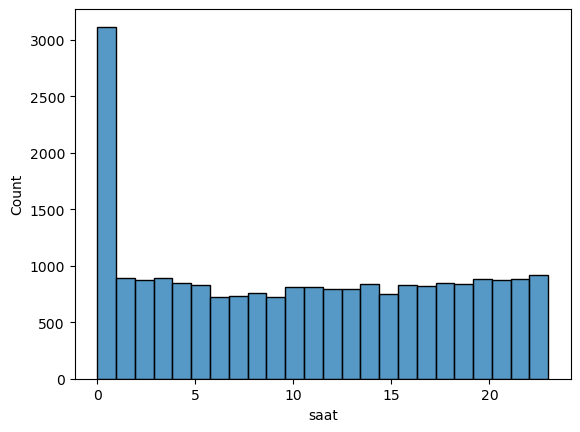

In [62]:
# sns.boxplot(df["saat"])
sns.histplot(data = df, x = "saat")

### Lag Feature

Üretecek olduğumuz gecikme featureları, bağımlı değişken üzerinden (xM) üzerinden üretilecek. Bağımlı değişkenden değişken türetmenin en büyük sorunu, overfite sebep olabilmesi. Overfitin önüne geçmek için yeni üreteceğimiz değişkenlere gürültü ekleyeceğiz.

Bu sayede bağımlı değişkenin gecikmelerindeki Patternları kullanabilirken, bire bir aynı olmadığı için overfitinde önüne geçmiş oluyoruz.

In [63]:
# random noise
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe)))

In [64]:
df = df.sort_values(by = ["depremin_olus_zamani","temizlenmis_yer"],
               axis = 0)

In [65]:
df.head()

,no,deprem kodu,enlem,boylam,derinlik,xm,yer,depremin_olus_zamani,temizlenmis_yer,ay,yil,ay_gun,hafta_gun,saat,aksam,yıl_gün,yıl_hafta,ay_basi,ay_sonu,çeyreklik
19902,19908.0,1.915021e+13,38.80,42.50,30.0,5.7,CEMALETTIN-AHLAT (BITLIS) [South West 3.7 km],1915-02-14 08:20:00.600,BITLIS,2,1915,14,6,8,0,45,6,0,0,1
19901,19907.0,1.915023e+13,37.70,43.10,30.0,5.5,MEZRA-BEYTUSSEBAP (SIRNAK) [North West 9.0 km],1915-02-28 12:47:02.400,SIRNAK,2,1915,28,6,12,0,59,8,0,1,1
19900,19906.0,1.915040e+13,40.50,44.50,35.0,4.9,AZERBAYCAN,1915-04-01 05:41:05.000,AZERBAYCAN,4,1915,1,3,5,0,91,13,1,0,2
19899,19905.0,1.915052e+13,37.62,39.47,10.0,5.5,CATLI-SIVEREK (SANLIURFA) [South East 3.5 km],1915-05-19 04:48:02.400,SANLIURFA,5,1915,19,2,4,1,139,20,0,0,2
19898,19904.0,1.915092e+13,40.00,43.00,15.0,4.4,EVYAPAN-KAGIZMAN (KARS) [South West 5.8 km],1915-09-23 07:20:01.000,KARS,9,1915,23,3,7,0,266,38,0,0,3


In [66]:
df.head()

,no,deprem kodu,enlem,boylam,derinlik,xm,yer,depremin_olus_zamani,temizlenmis_yer,ay,yil,ay_gun,hafta_gun,saat,aksam,yıl_gün,yıl_hafta,ay_basi,ay_sonu,çeyreklik
19902,19908.0,1.915021e+13,38.80,42.50,30.0,5.7,CEMALETTIN-AHLAT (BITLIS) [South West 3.7 km],1915-02-14 08:20:00.600,BITLIS,2,1915,14,6,8,0,45,6,0,0,1
19901,19907.0,1.915023e+13,37.70,43.10,30.0,5.5,MEZRA-BEYTUSSEBAP (SIRNAK) [North West 9.0 km],1915-02-28 12:47:02.400,SIRNAK,2,1915,28,6,12,0,59,8,0,1,1
19900,19906.0,1.915040e+13,40.50,44.50,35.0,4.9,AZERBAYCAN,1915-04-01 05:41:05.000,AZERBAYCAN,4,1915,1,3,5,0,91,13,1,0,2
19899,19905.0,1.915052e+13,37.62,39.47,10.0,5.5,CATLI-SIVEREK (SANLIURFA) [South East 3.5 km],1915-05-19 04:48:02.400,SANLIURFA,5,1915,19,2,4,1,139,20,0,0,2
19898,19904.0,1.915092e+13,40.00,43.00,15.0,4.4,EVYAPAN-KAGIZMAN (KARS) [South West 5.8 km],1915-09-23 07:20:01.000,KARS,9,1915,23,3,7,0,266,38,0,0,3


In [67]:
# lag features
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['deprem_lag_' + str(lag)] = dataframe.groupby(["temizlenmis_yer"])['xm'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [68]:
# çeşitli shiftler/lagler/gecikmeler girelim. Gecikme  o zamanki değer demekti unutma. 3 ay ve katları olacak şekilde bakıyorum! Quarter aldım.
df = lag_features(df, [1, 3, 7, 30, 60, 90, 180, 360])

In [69]:
df.isnull().sum()

no                       2208
deprem kodu              2208
enlem                       0
boylam                      0
derinlik                    0
xm                       2208
yer                      2208
depremin_olus_zamani        0
temizlenmis_yer             0
ay                          0
yil                         0
ay_gun                      0
hafta_gun                   0
saat                        0
aksam                       0
yıl_gün                     0
yıl_hafta                   0
ay_basi                     0
ay_sonu                     0
çeyreklik                   0
deprem_lag_1             2208
deprem_lag_3             2208
deprem_lag_7             2576
deprem_lag_30            4999
deprem_lag_60            6880
deprem_lag_90            8363
deprem_lag_180          11382
deprem_lag_360          14531
dtype: int64

In [70]:
df.head()

,no,deprem kodu,enlem,boylam,derinlik,xm,yer,depremin_olus_zamani,temizlenmis_yer,ay,...,ay_sonu,çeyreklik,deprem_lag_1,deprem_lag_3,deprem_lag_7,deprem_lag_30,deprem_lag_60,deprem_lag_90,deprem_lag_180,deprem_lag_360
19902,19908.0,1.915021e+13,38.80,42.50,30.0,5.7,CEMALETTIN-AHLAT (BITLIS) [South West 3.7 km],1915-02-14 08:20:00.600,BITLIS,2,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19901,19907.0,1.915023e+13,37.70,43.10,30.0,5.5,MEZRA-BEYTUSSEBAP (SIRNAK) [North West 9.0 km],1915-02-28 12:47:02.400,SIRNAK,2,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19900,19906.0,1.915040e+13,40.50,44.50,35.0,4.9,AZERBAYCAN,1915-04-01 05:41:05.000,AZERBAYCAN,4,...,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19899,19905.0,1.915052e+13,37.62,39.47,10.0,5.5,CATLI-SIVEREK (SANLIURFA) [South East 3.5 km],1915-05-19 04:48:02.400,SANLIURFA,5,...,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19898,19904.0,1.915092e+13,40.00,43.00,15.0,4.4,EVYAPAN-KAGIZMAN (KARS) [South West 5.8 km],1915-09-23 07:20:01.000,KARS,9,...,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Rolling Mean

In [71]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['deprem_roll_mean_' + str(window)] = dataframe.groupby(["temizlenmis_yer"])['xm']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [72]:
df = roll_mean_features(df, [10, 30, 60, 90, 180, 360])

In [73]:
df.isnull().sum()

no                       2208
deprem kodu              2208
enlem                       0
boylam                      0
derinlik                    0
xm                       2208
yer                      2208
depremin_olus_zamani        0
temizlenmis_yer             0
ay                          0
yil                         0
ay_gun                      0
hafta_gun                   0
saat                        0
aksam                       0
yıl_gün                     0
yıl_hafta                   0
ay_basi                     0
ay_sonu                     0
çeyreklik                   0
deprem_lag_1             2208
deprem_lag_3             2208
deprem_lag_7             2576
deprem_lag_30            4999
deprem_lag_60            6880
deprem_lag_90            8363
deprem_lag_180          11382
deprem_lag_360          14531
deprem_roll_mean_10      3741
deprem_roll_mean_30      3226
deprem_roll_mean_60      3226
deprem_roll_mean_90      3226
deprem_roll_mean_180     3226
deprem_rol

### Exponentially Weighted Mean Features

In [74]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['deprem_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["temizlenmis_yer"])['xm'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [75]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [1, 3, 7, 30, 60, 90, 180, 360]

In [76]:
df = ewm_features(df, alphas, lags)

In [77]:
df.isnull().sum()

no                               2208
deprem kodu                      2208
enlem                               0
boylam                              0
derinlik                            0
xm                               2208
yer                              2208
depremin_olus_zamani                0
temizlenmis_yer                     0
ay                                  0
yil                                 0
ay_gun                              0
hafta_gun                           0
saat                                0
aksam                               0
yıl_gün                             0
yıl_hafta                           0
ay_basi                             0
ay_sonu                             0
çeyreklik                           0
deprem_lag_1                     2208
deprem_lag_3                     2208
deprem_lag_7                     2576
deprem_lag_30                    4999
deprem_lag_60                    6880
deprem_lag_90                    8363
deprem_lag_1

### One Hot Encoder

In [298]:
df = pd.get_dummies(df, columns=['temizlenmis_yer'])

In [299]:
df.shape

(19903, 376)

### Log1p (Bağımlı değişkenin logaritması)

In [80]:
df['xm'] = np.log1p(df["xm"].values)

## Custom Cost Function

In [81]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

## Time-Based Validation Sets

In [82]:
df["depremin_olus_zamani"].min(), df["depremin_olus_zamani"].max()

(Timestamp('1915-02-14 08:20:00.600000'), Timestamp('2023-09-15 00:00:00'))

In [83]:
# 2023 3 ayı validasyon, öncekilerde eğitim

# 2023'nin başına kadar (2022'nın sonuna kadar) train seti.
train = df.loc[(df["depremin_olus_zamani"] < "2023-01-01"), :]

# 2023'nin ilk 3'ayı validasyon seti.
val = df.loc[(df["depremin_olus_zamani"] >= "2023-01-01") & (df["depremin_olus_zamani"] < "2023-04-01"), :]

In [84]:
df.columns

Index(['no', 'deprem kodu', 'enlem', 'boylam', 'derinlik', 'xm', 'yer',
       'depremin_olus_zamani', 'ay', 'yil',
       ...
       'temizlenmis_yer_YESILYURT-ALTINTAS KUTAHYA ', 'temizlenmis_yer_YOZGAT',
       'temizlenmis_yer_YUKARIDOLAYLAR-SIMAV KUTAHYA ',
       'temizlenmis_yer_YUKARIYONCAAGAC-HISARCIK KUTAHYA ',
       'temizlenmis_yer_YUMRUTAS-GEDIZ KUTAHYA ',
       'temizlenmis_yer_YUNUSLAR-GEDIZ KUTAHYA ',
       'temizlenmis_yer_YUYLUK-DUMLUPINAR KUTAHYA ',
       'temizlenmis_yer_ZAFERTEPECALKOY-ALTINTAS KUTAHYA ',
       'temizlenmis_yer_ZONGULDAK', 'temizlenmis_yer_iZMiR'],
      dtype='object', length=441)

In [85]:
cols = [col for col in df.columns if col not in ['deprem kodu',"no","yer","depremin_olus_zamani","temizlenmis_yer","xm"]]

In [ ]:
df.columns

In [86]:
Y_train = train['xm']
X_train = train[cols]

Y_val = val['xm']
X_val = val[cols]

In [87]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((18424,), (18424, 436), (1383,), (1383, 436))

## OPTUNA

In [135]:
def objective(trial):
    
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart'])

    params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': boosting_type,
    'verbosity': 0,
    'boost_from_average': 'false',
    'num_threads': 16,
    'num_leaves': 110,
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
    'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
    'subsample_freq': trial.suggest_int('subsample_freq', 1, 5),
    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 0.9),
    'lambda_l1': 0.7,
    'lambda_l2': 0.7,
    'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 40, 100),
    'force_col_wise':'True',
    }
    train_data = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
    val_data = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

    # Train the LightGBM model
    model = lgb.train(params, train_data, valid_sets=[train_data, val_data])

    # Evaluate the model on the validation set using custom SMAPE function
    val_preds = model.predict(X_val)
    rmse_train = mean_squared_error(Y_val, val_preds, squared=True)
    trial.set_user_attr('rmse_train', rmse_train)
    return rmse_train

In [137]:
study = optuna.create_study(direction='minimize')  # Minimize custom SMAPE
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# Print the best trial
best_trial = study.best_trial
print(f"Best trial - Custom SMAPE: {best_trial.value:.4f}")
print(f"Best trial - Params: {best_trial.params}")


[I 2023-09-11 16:05:43,041] A new study created in memory with name: no-name-264b7e7e-d4fe-48ff-8b9c-8d1f3d55a0be
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rele

[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:05:44,433] Trial 0 finished with value: 0.004742550941178438 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.09634077085994701, 'subsample': 0.9566238633419473, 'subsample_freq': 4, 'feature_fraction': 0.7911209976834384, 'min_child_samples': 11, 'min_data_in_leaf': 63}. Best is trial 0 with value: 0.004742550941178438.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('

[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:05:44,937] Trial 1 finished with value: 0.020053235358096798 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.13593897671888575, 'subsample': 0.766962768484197, 'subsample_freq': 5, 'feature_fraction': 0.7356463619918221, 'min_child_samples': 24, 'min_data_in_leaf': 47}. Best is trial 0 with value: 0.004742550941178438.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('s

[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:05:45,394] Trial 2 finished with value: 1.153368710946117 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.009814908496577436, 'subsample': 0.7311038425473951, 'subsample_freq': 1, 'feature_fraction': 0.5226542819547293, 'min_child_samples': 44, 'min_data_in_leaf': 47}. Best is trial 0 with value: 0.004742550941178438.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 0

[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:05:45,903] Trial 3 finished with value: 1.4226655294024786 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.007114699975406645, 'subsample': 0.9367017391207473, 'subsample_freq': 5, 'feature_fraction': 0.7931227927391375, 'min_child_samples': 36, 'min_data_in_leaf': 64}. Best is trial 0 with value: 0.004742550941178438.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('s

[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:05:46,415] Trial 4 finished with value: 1.4101706990206184 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.007221352374312381, 'subsample': 0.907589702638792, 'subsample_freq': 2, 'feature_fraction': 0.5772179982424953, 'min_child_samples': 18, 'min_data_in_leaf': 49}. Best is trial 0 with value: 0.004742550941178438.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 0

[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:05:46,918] Trial 5 finished with value: 0.3346832487259214 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.02896976684232291, 'subsample': 0.8726688881639304, 'subsample_freq': 2, 'feature_fraction': 0.5375903542406343, 'min_child_samples': 16, 'min_data_in_leaf': 67}. Best is trial 0 with value: 0.004742550941178438.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('su

[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:05:47,447] Trial 6 finished with value: 0.09418176430417939 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.05912332158118466, 'subsample': 0.8607802588156487, 'subsample_freq': 4, 'feature_fraction': 0.8733324838886776, 'min_child_samples': 27, 'min_data_in_leaf': 66}. Best is trial 0 with value: 0.004742550941178438.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 0

[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=39 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:05:47,904] Trial 7 finished with value: 0.008330166948465254 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.042057524649142454, 'subsample': 0.7290163293059575, 'subsample_freq': 2, 'feature_fraction': 0.5167775520148417, 'min_child_samples': 39, 'min_data_in_leaf': 97}. Best is trial 0 with value: 0.004742550941178438.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 0

[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:05:48,385] Trial 8 finished with value: 0.4771952615246576 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.022790980475043878, 'subsample': 0.8690646499696877, 'subsample_freq': 5, 'feature_fraction': 0.5407041190010042, 'min_child_samples': 30, 'min_data_in_leaf': 96}. Best is trial 0 with value: 0.004742550941178438.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 0

[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:05:48,851] Trial 9 finished with value: 1.4482550915273054 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0068845872110789, 'subsample': 0.7107466199774668, 'subsample_freq': 3, 'feature_fraction': 0.8529881106715849, 'min_child_samples': 48, 'min_data_in_leaf': 56}. Best is trial 0 with value: 0.004742550941178438.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 0

[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:05:50,488] Trial 10 finished with value: 0.002812669906184002 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.18688521669415376, 'subsample': 0.984887193011041, 'subsample_freq': 4, 'feature_fraction': 0.6647407630906452, 'min_child_samples': 12, 'min_data_in_leaf': 81}. Best is trial 10 with value: 0.002812669906184002.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform(

[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:05:51,997] Trial 11 finished with value: 0.002838795648611592 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.18593531721474568, 'subsample': 0.9919228854213976, 'subsample_freq': 4, 'feature_fraction': 0.6585094605346625, 'min_child_samples': 12, 'min_data_in_leaf': 83}. Best is trial 10 with value: 0.002812669906184002.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:05:53,389] Trial 12 finished with value: 0.002916981598891266 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1759957190640436, 'subsample': 0.9980240350310322, 'subsample_freq': 4, 'feature_fraction': 0.6388735192233423, 'min_child_samples': 10, 'min_data_in_leaf': 82}. Best is trial 10 with value: 0.002812669906184002.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform(

[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:05:54,955] Trial 13 finished with value: 0.0026598802636597697 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1955923384641409, 'subsample': 0.991322421290636, 'subsample_freq': 3, 'feature_fraction': 0.6612958153945755, 'min_child_samples': 20, 'min_data_in_leaf': 81}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:05:56,139] Trial 14 finished with value: 0.0047850821282974685 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.09850358825569369, 'subsample': 0.960254909271776, 'subsample_freq': 3, 'feature_fraction': 0.6899143202799074, 'min_child_samples': 20, 'min_data_in_leaf': 79}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:05:57,529] Trial 15 finished with value: 0.002772952705957806 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.19444709843843397, 'subsample': 0.9189118287329376, 'subsample_freq': 3, 'feature_fraction': 0.6150017371061123, 'min_child_samples': 22, 'min_data_in_leaf': 76}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:05:58,626] Trial 16 finished with value: 0.004569436108399898 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.10620757409821856, 'subsample': 0.9249866973972803, 'subsample_freq': 3, 'feature_fraction': 0.6226796359577967, 'min_child_samples': 23, 'min_data_in_leaf': 75}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=34 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:05:59,396] Trial 17 finished with value: 0.006420404561014907 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.06500015661012902, 'subsample': 0.906552727755126, 'subsample_freq': 1, 'feature_fraction': 0.60726335099038, 'min_child_samples': 34, 'min_data_in_leaf': 90}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('

[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=27 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:00,821] Trial 18 finished with value: 0.004123783062597756 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.12854046305248815, 'subsample': 0.958293359936313, 'subsample_freq': 2, 'feature_fraction': 0.5934226606606368, 'min_child_samples': 27, 'min_data_in_leaf': 89}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:01,864] Trial 19 finished with value: 0.005950022425603081 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.07549392245797874, 'subsample': 0.810505376896277, 'subsample_freq': 3, 'feature_fraction': 0.7115886927836965, 'min_child_samples': 21, 'min_data_in_leaf': 74}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:03,347] Trial 20 finished with value: 0.0036432619312878026 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1401255752415578, 'subsample': 0.8974234806730766, 'subsample_freq': 3, 'feature_fraction': 0.5755622290313502, 'min_child_samples': 16, 'min_data_in_leaf': 58}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:04,949] Trial 21 finished with value: 0.002767211052356702 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.19130250156455902, 'subsample': 0.979426956400854, 'subsample_freq': 4, 'feature_fraction': 0.6650771037003181, 'min_child_samples': 15, 'min_data_in_leaf': 88}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:06,535] Trial 22 finished with value: 0.0027806410466934754 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.19635290106722658, 'subsample': 0.9734631742609912, 'subsample_freq': 3, 'feature_fraction': 0.6430922086332126, 'min_child_samples': 16, 'min_data_in_leaf': 89}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifo

[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:07,926] Trial 23 finished with value: 0.0036101299813713753 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.13877594849022262, 'subsample': 0.9984752569321211, 'subsample_freq': 4, 'feature_fraction': 0.6929816816015564, 'min_child_samples': 24, 'min_data_in_leaf': 74}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifo

[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:08,888] Trial 24 finished with value: 0.00556528423813749 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.08248866937531252, 'subsample': 0.9377758096116026, 'subsample_freq': 2, 'feature_fraction': 0.6292993316478407, 'min_child_samples': 28, 'min_data_in_leaf': 86}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:10,125] Trial 25 finished with value: 0.004331674721171357 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.11843303976580903, 'subsample': 0.9694086954319417, 'subsample_freq': 4, 'feature_fraction': 0.669774013804678, 'min_child_samples': 19, 'min_data_in_leaf': 93}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[I 2023-09-11 16:06:11,400] Trial 26 finished with value: 0.003002351815142997 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.19812102496710723, 'subsample': 0.9392171622542553, 'subsample_freq': 3, 'feature_fraction': 0.608232357732204, 'min_child_samples': 16, 'min_data_in_leaf': 100}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=31 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:12,692] Trial 27 finished with value: 0.003451435374602788 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.15254420837833366, 'subsample': 0.9733361963716972, 'subsample_freq': 3, 'feature_fraction': 0.5714327062457971, 'min_child_samples': 31, 'min_data_in_leaf': 78}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:13,942] Trial 28 finished with value: 0.0042672817409076975 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.11303601272780156, 'subsample': 0.947514505288872, 'subsample_freq': 5, 'feature_fraction': 0.7235603529825652, 'min_child_samples': 14, 'min_data_in_leaf': 70}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:14,966] Trial 29 finished with value: 0.005249173253944345 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.08679889488288262, 'subsample': 0.9572448320479956, 'subsample_freq': 4, 'feature_fraction': 0.7524273490399291, 'min_child_samples': 22, 'min_data_in_leaf': 85}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:16,460] Trial 30 finished with value: 0.0033820271411186516 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.15139086925550654, 'subsample': 0.9825032924834871, 'subsample_freq': 3, 'feature_fraction': 0.6793528869339855, 'min_child_samples': 25, 'min_data_in_leaf': 71}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifo

[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:18,060] Trial 31 finished with value: 0.002829252802659617 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.19202841141295798, 'subsample': 0.9748650734570147, 'subsample_freq': 3, 'feature_fraction': 0.6519945982275492, 'min_child_samples': 18, 'min_data_in_leaf': 88}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:19,507] Trial 32 finished with value: 0.003605779356266828 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1502293545000726, 'subsample': 0.9716499640265899, 'subsample_freq': 3, 'feature_fraction': 0.6411022977789615, 'min_child_samples': 13, 'min_data_in_leaf': 92}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:20,801] Trial 33 finished with value: 0.00454981612961085 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.11054420422425702, 'subsample': 0.9260163801900768, 'subsample_freq': 2, 'feature_fraction': 0.6244451066671822, 'min_child_samples': 15, 'min_data_in_leaf': 79}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:22,562] Trial 34 finished with value: 0.003430942977959116 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.15121239169503606, 'subsample': 0.9995106003712769, 'subsample_freq': 3, 'feature_fraction': 0.692578825283332, 'min_child_samples': 19, 'min_data_in_leaf': 87}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:24,227] Trial 35 finished with value: 0.0027912225500143634 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.19770693600970418, 'subsample': 0.9568909356854791, 'subsample_freq': 5, 'feature_fraction': 0.6567052953183076, 'min_child_samples': 10, 'min_data_in_leaf': 94}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifo

[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:25,686] Trial 36 finished with value: 0.004797967743131853 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.09863465926944398, 'subsample': 0.9772260089882583, 'subsample_freq': 2, 'feature_fraction': 0.674270661292541, 'min_child_samples': 18, 'min_data_in_leaf': 76}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=24 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:26,222] Trial 37 finished with value: 0.022883536647722504 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.125065950981707, 'subsample': 0.9222230436736848, 'subsample_freq': 1, 'feature_fraction': 0.7083321043656013, 'min_child_samples': 24, 'min_data_in_leaf': 41}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform(

[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:27,719] Trial 38 finished with value: 0.0034051095141305414 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.15483716248471502, 'subsample': 0.9505778161004729, 'subsample_freq': 4, 'feature_fraction': 0.7494568021154792, 'min_child_samples': 21, 'min_data_in_leaf': 84}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifo

[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:28,221] Trial 39 finished with value: 0.014012502199415633 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.16863273603103732, 'subsample': 0.8818672306298824, 'subsample_freq': 2, 'feature_fraction': 0.6399116942431209, 'min_child_samples': 14, 'min_data_in_leaf': 70}. Best is trial 13 with value: 0.0026598802636597697.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 0

[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=40 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:29,681] Trial 40 finished with value: 0.0038243026525401846 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.13318527107656944, 'subsample': 0.9421892939462629, 'subsample_freq': 3, 'feature_fraction': 0.5985174594412029, 'min_child_samples': 40, 'min_data_in_leaf': 63}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifo

[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:31,469] Trial 41 finished with value: 0.0027655363813057355 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1991169109725824, 'subsample': 0.9605516575373173, 'subsample_freq': 5, 'feature_fraction': 0.6490659784460259, 'min_child_samples': 10, 'min_data_in_leaf': 95}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:32,999] Trial 42 finished with value: 0.003269232785132305 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.17048475255668463, 'subsample': 0.9652027815616567, 'subsample_freq': 5, 'feature_fraction': 0.6517225971078853, 'min_child_samples': 17, 'min_data_in_leaf': 91}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:34,311] Trial 43 finished with value: 0.004205588423939923 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.12452138846411327, 'subsample': 0.9798234208866193, 'subsample_freq': 5, 'feature_fraction': 0.6215201242074766, 'min_child_samples': 12, 'min_data_in_leaf': 99}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:34,890] Trial 44 finished with value: 0.011800545642105262 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.19351907093013662, 'subsample': 0.9878904304731256, 'subsample_freq': 4, 'feature_fraction': 0.6679710520617556, 'min_child_samples': 10, 'min_data_in_leaf': 95}. Best is trial 13 with value: 0.0026598802636597697.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=81


C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2023-09-11 16:06:36,280] Trial 45 finished with value: 0.0033341604093183068 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.16222840055257418, 'subsample': 0.9525390689366574, 'subsample_freq': 5, 'feature_fraction': 0.5613932176808241, 'min_child_samples': 14, 'min_data_in_leaf': 81}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifo

[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:37,839] Trial 46 finished with value: 0.0027923998261450604 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.19878890486052653, 'subsample': 0.9877756552205328, 'subsample_freq': 4, 'feature_fraction': 0.5887919061784098, 'min_child_samples': 12, 'min_data_in_leaf': 97}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifo

[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:39,114] Trial 47 finished with value: 0.005263013022043597 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.09145577614880063, 'subsample': 0.9282700219770013, 'subsample_freq': 4, 'feature_fraction': 0.5031244625176723, 'min_child_samples': 16, 'min_data_in_leaf': 88}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=26 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:39,660] Trial 48 finished with value: 0.15681118704975822 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.04501162356922349, 'subsample': 0.9686100286649441, 'subsample_freq': 3, 'feature_fraction': 0.6098762604895401, 'min_child_samples': 26, 'min_data_in_leaf': 83}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:40,883] Trial 49 finished with value: 0.00454823057758491 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.10709277424004132, 'subsample': 0.9885909452605169, 'subsample_freq': 4, 'feature_fraction': 0.6850400339880849, 'min_child_samples': 20, 'min_data_in_leaf': 90}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=29 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:42,187] Trial 50 finished with value: 0.0030461587772976357 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1689247593748757, 'subsample': 0.9461599840088167, 'subsample_freq': 3, 'feature_fraction': 0.6465637069437133, 'min_child_samples': 29, 'min_data_in_leaf': 78}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:43,770] Trial 51 finished with value: 0.002876539014608422 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.196863444523886, 'subsample': 0.9590326659190893, 'subsample_freq': 5, 'feature_fraction': 0.6588310165694892, 'min_child_samples': 10, 'min_data_in_leaf': 95}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform(

[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:45,279] Trial 52 finished with value: 0.003940900545549839 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1339239596158644, 'subsample': 0.9645417591924976, 'subsample_freq': 5, 'feature_fraction': 0.6658733671280047, 'min_child_samples': 11, 'min_data_in_leaf': 95}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:46,903] Trial 53 finished with value: 0.003203980798198317 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.17367938156298596, 'subsample': 0.9343605041338314, 'subsample_freq': 5, 'feature_fraction': 0.6308377507974167, 'min_child_samples': 13, 'min_data_in_leaf': 93}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:48,755] Trial 54 finished with value: 0.0032812448162180823 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.17255680689121866, 'subsample': 0.9137332955663289, 'subsample_freq': 5, 'feature_fraction': 0.6504010498743271, 'min_child_samples': 48, 'min_data_in_leaf': 87}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifo

[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:50,547] Trial 55 finished with value: 0.0036032368670292424 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.13984779089239407, 'subsample': 0.9546616804680903, 'subsample_freq': 5, 'feature_fraction': 0.7047315932183195, 'min_child_samples': 15, 'min_data_in_leaf': 81}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifo

[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:52,250] Trial 56 finished with value: 0.0042638453455580705 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.11960580278420237, 'subsample': 0.99976136503297, 'subsample_freq': 3, 'feature_fraction': 0.6177074227963422, 'min_child_samples': 10, 'min_data_in_leaf': 98}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=18 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:54,096] Trial 57 finished with value: 0.0032439573246400132 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.16935132005807607, 'subsample': 0.9822921840501022, 'subsample_freq': 4, 'feature_fraction': 0.6836025968763397, 'min_child_samples': 18, 'min_data_in_leaf': 93}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifo

[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=22 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:54,815] Trial 58 finished with value: 0.01877711488673024 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.14008206832052608, 'subsample': 0.9405637426662191, 'subsample_freq': 4, 'feature_fraction': 0.6362009561149106, 'min_child_samples': 22, 'min_data_in_leaf': 85}. Best is trial 13 with value: 0.0026598802636597697.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 0

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:56,331] Trial 59 finished with value: 0.004734617118527763 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.10583642314448927, 'subsample': 0.9686244646528387, 'subsample_freq': 3, 'feature_fraction': 0.6607910609899758, 'min_child_samples': 12, 'min_data_in_leaf': 90}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:06:58,241] Trial 60 finished with value: 0.0027223865293070333 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.19287844577873225, 'subsample': 0.9909981898084368, 'subsample_freq': 5, 'feature_fraction': 0.6018306225423731, 'min_child_samples': 15, 'min_data_in_leaf': 84}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifo

[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:00,023] Trial 61 finished with value: 0.0027674140164984065 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.18927274136331584, 'subsample': 0.9904097069938239, 'subsample_freq': 5, 'feature_fraction': 0.6046806075589769, 'min_child_samples': 16, 'min_data_in_leaf': 76}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifo

[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:01,615] Trial 62 finished with value: 0.003286067442240578 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.15653072052766925, 'subsample': 0.9897711138384566, 'subsample_freq': 5, 'feature_fraction': 0.5909996714973187, 'min_child_samples': 16, 'min_data_in_leaf': 76}. Best is trial 13 with value: 0.0026598802636597697.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:03,463] Trial 63 finished with value: 0.002471260446113292 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.19986850305793402, 'subsample': 0.9778880064060288, 'subsample_freq': 5, 'feature_fraction': 0.6153367760626559, 'min_child_samples': 17, 'min_data_in_leaf': 67}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:05,239] Trial 64 finished with value: 0.0028413645755112535 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.18095000157409707, 'subsample': 0.9890081049350299, 'subsample_freq': 5, 'feature_fraction': 0.6117628680271128, 'min_child_samples': 19, 'min_data_in_leaf': 67}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:06,964] Trial 65 finished with value: 0.0032723248816181084 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1527951753045698, 'subsample': 0.98176368628733, 'subsample_freq': 5, 'feature_fraction': 0.5995213248645432, 'min_child_samples': 17, 'min_data_in_leaf': 61}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('

[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=32 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:08,715] Trial 66 finished with value: 0.003996759194284576 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.12452669700672041, 'subsample': 0.9993321059450179, 'subsample_freq': 5, 'feature_fraction': 0.6297771766941551, 'min_child_samples': 32, 'min_data_in_leaf': 73}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=21 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:10,521] Trial 67 finished with value: 0.002856982021540259 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.18111831011256546, 'subsample': 0.9656669579953614, 'subsample_freq': 5, 'feature_fraction': 0.5620291563699272, 'min_child_samples': 21, 'min_data_in_leaf': 72}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:12,257] Trial 68 finished with value: 0.0035918567896059267 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.14115126218463353, 'subsample': 0.978472449105921, 'subsample_freq': 5, 'feature_fraction': 0.5826926758860678, 'min_child_samples': 15, 'min_data_in_leaf': 68}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:14,025] Trial 69 finished with value: 0.002894339868080828 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1786264738066071, 'subsample': 0.9916516446648557, 'subsample_freq': 5, 'feature_fraction': 0.6044942631169316, 'min_child_samples': 23, 'min_data_in_leaf': 79}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform(

[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:15,465] Trial 70 finished with value: 0.004049169751916393 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.11604368746309324, 'subsample': 0.9758685340904251, 'subsample_freq': 4, 'feature_fraction': 0.6202475995803146, 'min_child_samples': 17, 'min_data_in_leaf': 54}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:17,312] Trial 71 finished with value: 0.002631634200946276 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.19478807043540447, 'subsample': 0.9738910887504737, 'subsample_freq': 3, 'feature_fraction': 0.6325917363168959, 'min_child_samples': 50, 'min_data_in_leaf': 76}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:19,080] Trial 72 finished with value: 0.002639052571789894 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.19751641092592764, 'subsample': 0.9615445240245948, 'subsample_freq': 3, 'feature_fraction': 0.6380800937250426, 'min_child_samples': 45, 'min_data_in_leaf': 76}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:20,906] Trial 73 finished with value: 0.0031798603076916825 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.15768224620239285, 'subsample': 0.9587319156059462, 'subsample_freq': 3, 'feature_fraction': 0.6390784389783598, 'min_child_samples': 50, 'min_data_in_leaf': 65}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:22,903] Trial 74 finished with value: 0.0028299330830576716 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.17850480501329152, 'subsample': 0.9748218066417728, 'subsample_freq': 2, 'feature_fraction': 0.6725826615489277, 'min_child_samples': 42, 'min_data_in_leaf': 69}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:24,889] Trial 75 finished with value: 0.0025741665658239763 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.19970119561085553, 'subsample': 0.9907027816888747, 'subsample_freq': 3, 'feature_fraction': 0.6328070700684069, 'min_child_samples': 46, 'min_data_in_leaf': 77}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:26,538] Trial 76 finished with value: 0.003585193231704581 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1444417937287933, 'subsample': 0.9469317343229339, 'subsample_freq': 3, 'feature_fraction': 0.6295874045834766, 'min_child_samples': 45, 'min_data_in_leaf': 78}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform(

[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:28,271] Trial 77 finished with value: 0.0033280234558474885 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.16040519302450074, 'subsample': 0.9634612347630862, 'subsample_freq': 3, 'feature_fraction': 0.6443080679620652, 'min_child_samples': 47, 'min_data_in_leaf': 83}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=37 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:28,995] Trial 78 finished with value: 0.011393171583501241 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.1973258260581123, 'subsample': 0.9830742886433078, 'subsample_freq': 3, 'feature_fraction': 0.6766445313901998, 'min_child_samples': 37, 'min_data_in_leaf': 74}. Best is trial 63 with value: 0.002471260446113292.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 0

[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:30,836] Trial 79 finished with value: 0.0031656781091729384 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1636850747979716, 'subsample': 0.9938145320670442, 'subsample_freq': 3, 'feature_fraction': 0.6505857207354933, 'min_child_samples': 45, 'min_data_in_leaf': 81}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:32,345] Trial 80 finished with value: 0.003818496783563402 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1326549917548162, 'subsample': 0.9722585534829918, 'subsample_freq': 2, 'feature_fraction': 0.6184884662063201, 'min_child_samples': 50, 'min_data_in_leaf': 72}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform(

[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:34,046] Trial 81 finished with value: 0.002543771795656796 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.19989478032996202, 'subsample': 0.9941052257187271, 'subsample_freq': 3, 'feature_fraction': 0.6015320441390906, 'min_child_samples': 48, 'min_data_in_leaf': 76}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:36,158] Trial 82 finished with value: 0.00282391186033209 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.18057972302028652, 'subsample': 0.9996912336668361, 'subsample_freq': 3, 'feature_fraction': 0.6327159549210613, 'min_child_samples': 48, 'min_data_in_leaf': 79}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform(

[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:38,113] Trial 83 finished with value: 0.0033393092983679414 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1574537107726712, 'subsample': 0.982961476382757, 'subsample_freq': 3, 'feature_fraction': 0.6592453841595134, 'min_child_samples': 47, 'min_data_in_leaf': 80}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform(

[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:39,796] Trial 84 finished with value: 0.003531773885851877 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.14603233407692284, 'subsample': 0.993605634436069, 'subsample_freq': 3, 'feature_fraction': 0.614752040922229, 'min_child_samples': 42, 'min_data_in_leaf': 83}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('

[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:41,459] Trial 85 finished with value: 0.0026142216747290143 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1992481236068615, 'subsample': 0.953286629372028, 'subsample_freq': 3, 'feature_fraction': 0.6276082876478257, 'min_child_samples': 49, 'min_data_in_leaf': 75}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform(

[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:43,248] Trial 86 finished with value: 0.0026492554136730673 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1999425083974521, 'subsample': 0.9504113475539683, 'subsample_freq': 3, 'feature_fraction': 0.5984783951105526, 'min_child_samples': 49, 'min_data_in_leaf': 74}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:44,943] Trial 87 finished with value: 0.002810003807257576 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1822920283061831, 'subsample': 0.9704999004330315, 'subsample_freq': 3, 'feature_fraction': 0.5969836047973712, 'min_child_samples': 49, 'min_data_in_leaf': 74}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform(

[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:46,371] Trial 88 finished with value: 0.003270940773135018 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1659842550029642, 'subsample': 0.9334102015614325, 'subsample_freq': 3, 'feature_fraction': 0.6248949843829139, 'min_child_samples': 46, 'min_data_in_leaf': 77}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform(

[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:47,551] Trial 89 finished with value: 0.004065563145829404 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.12627834216784867, 'subsample': 0.9491764894119732, 'subsample_freq': 3, 'feature_fraction': 0.5807046818502886, 'min_child_samples': 43, 'min_data_in_leaf': 75}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:48,109] Trial 90 finished with value: 0.01135368749879969 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.19975309840682068, 'subsample': 0.9522934336822287, 'subsample_freq': 3, 'feature_fraction': 0.6050810431600887, 'min_child_samples': 49, 'min_data_in_leaf': 72}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform(

[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:49,637] Trial 91 finished with value: 0.0029470858547145334 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.17847751012279003, 'subsample': 0.9583251343481297, 'subsample_freq': 3, 'feature_fraction': 0.5896201598088349, 'min_child_samples': 47, 'min_data_in_leaf': 77}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:51,140] Trial 92 finished with value: 0.0027272330472696 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1853459587101008, 'subsample': 0.9783666507775483, 'subsample_freq': 3, 'feature_fraction': 0.6389930717552699, 'min_child_samples': 49, 'min_data_in_leaf': 70}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('s

[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=49 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:52,719] Trial 93 finished with value: 0.0034768870562801434 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.14599587259562918, 'subsample': 0.9769202871922532, 'subsample_freq': 3, 'feature_fraction': 0.6132035090820411, 'min_child_samples': 49, 'min_data_in_leaf': 70}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_unifor

[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:54,494] Trial 94 finished with value: 0.0028900214543424816 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.166626900997318, 'subsample': 0.9856433447810173, 'subsample_freq': 3, 'feature_fraction': 0.6241719805193306, 'min_child_samples': 45, 'min_data_in_leaf': 62}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform(

[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:56,199] Trial 95 finished with value: 0.0027586479854625396 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1813082927134191, 'subsample': 0.9647766364074797, 'subsample_freq': 3, 'feature_fraction': 0.6357121284686692, 'min_child_samples': 50, 'min_data_in_leaf': 68}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=46 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:57,744] Trial 96 finished with value: 0.0037720140525072106 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1325818836088718, 'subsample': 0.9695770396417707, 'subsample_freq': 3, 'feature_fraction': 0.6395562825833411, 'min_child_samples': 46, 'min_data_in_leaf': 75}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:07:59,398] Trial 97 finished with value: 0.0024813390099048273 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1977940502772842, 'subsample': 0.9944302303118296, 'subsample_freq': 3, 'feature_fraction': 0.598826200360033, 'min_child_samples': 44, 'min_data_in_leaf': 66}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform(

[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:08:00,994] Trial 98 finished with value: 0.0024886105770222213 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1993808150911916, 'subsample': 0.9965892110972007, 'subsample_freq': 2, 'feature_fraction': 0.5987648150316827, 'min_child_samples': 44, 'min_data_in_leaf': 66}. Best is trial 63 with value: 0.002471260446113292.
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\614784657.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform

[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=44 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-09-11 16:08:02,482] Trial 99 finished with value: 0.0033169069893999852 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.15097518366136584, 'subsample': 0.9929709796958841, 'subsample_freq': 2, 'feature_fraction': 0.5952405713363155, 'min_child_samples': 44, 'min_data_in_leaf': 65}. Best is trial 63 with value: 0.002471260446113292.


Best trial - Custom SMAPE: 0.0025
Best trial - Params: {'boosting_type': 'gbdt', 'learning_rate': 0.19986850305793402, 'subsample': 0.9778880064060288, 'subsample_freq': 5, 'feature_fraction': 0.6153367760626559, 'min_child_samples': 17, 'min_data_in_leaf': 67}


In [138]:
print(f"Best trial - Custom SMAPE: {best_trial.value:.4f}")
print(f"Best trial - Params: {best_trial.params}")

Best trial - Custom SMAPE: 0.0025
Best trial - Params: {'boosting_type': 'gbdt', 'learning_rate': 0.19986850305793402, 'subsample': 0.9778880064060288, 'subsample_freq': 5, 'feature_fraction': 0.6153367760626559, 'min_child_samples': 17, 'min_data_in_leaf': 67}


## Model

In [88]:
########################
# LightGBM ile Zaman Serisi Modeli, kg knkm
########################

LightGBM Hiperparametre optimizasyonunu şirket sunucusu üzerinde koşturdum. Localde inanılmaz yavaş. <br>
Hiperparametre tuning işlemini Optuna ile yaptım. Yardım aldığım kaynak: [optuna döküman](https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258)

In [89]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.05,
              'feature_fraction': 0.8,
              'max_depth': 15,
              'num_boost_round': 30000,
              'early_stopping_rounds': 3000,
              'nthread': -1}
# metric mae: l1, absolute loss, mean_absolute_error, regression_l1
# mse: l2, square loss, mean_squared_error, mse, regression_l2, regression
# rmse, root square loss, root_mean_squared_error, l2_root
# mape, MAPE loss, mean_absolute_percentage_error

# num_leaves: bir ağaçtaki maksimum yaprak sayısı
# learning_rate: shrinkage_rate, eta
# feature_fraction: rf'nin random subspace özelliği. her iterasyonda rastgele göz önünde bulundurulacak değişken sayısı.
# max_depth: maksimum derinlik
# num_boost_round: n_estimators, number of boosting iterations. En az 10000-15000 civarı yapmak lazım.

# early_stopping_rounds: validasyon setindeki metrik belirli bir early_stopping_rounds'da ilerlemiyorsa yani
# hata düşmüyorsa modellemeyi durdur.
# hem train süresini kısaltır hem de overfit'e engel olur.
# nthread: num_thread, nthread, nthreads, n_jobs;

In [90]:
cols

['enlem',
 'boylam',
 'derinlik',
 'ay',
 'yil',
 'ay_gun',
 'hafta_gun',
 'saat',
 'aksam',
 'yıl_gün',
 'yıl_hafta',
 'ay_basi',
 'ay_sonu',
 'çeyreklik',
 'deprem_lag_1',
 'deprem_lag_3',
 'deprem_lag_7',
 'deprem_lag_30',
 'deprem_lag_60',
 'deprem_lag_90',
 'deprem_lag_180',
 'deprem_lag_360',
 'deprem_roll_mean_10',
 'deprem_roll_mean_30',
 'deprem_roll_mean_60',
 'deprem_roll_mean_90',
 'deprem_roll_mean_180',
 'deprem_roll_mean_360',
 'deprem_ewm_alpha_095_lag_1',
 'deprem_ewm_alpha_095_lag_3',
 'deprem_ewm_alpha_095_lag_7',
 'deprem_ewm_alpha_095_lag_30',
 'deprem_ewm_alpha_095_lag_60',
 'deprem_ewm_alpha_095_lag_90',
 'deprem_ewm_alpha_095_lag_180',
 'deprem_ewm_alpha_095_lag_360',
 'deprem_ewm_alpha_09_lag_1',
 'deprem_ewm_alpha_09_lag_3',
 'deprem_ewm_alpha_09_lag_7',
 'deprem_ewm_alpha_09_lag_30',
 'deprem_ewm_alpha_09_lag_60',
 'deprem_ewm_alpha_09_lag_90',
 'deprem_ewm_alpha_09_lag_180',
 'deprem_ewm_alpha_09_lag_360',
 'deprem_ewm_alpha_08_lag_1',
 'deprem_ewm_alpha_08_

Feature'ın önemi nasıl belli olur:
* Regresyon problemeri için SSE, MSE gibi değerler feature kullnılmadan önce ve kullanıldıktan sonra tekrar hesaplandığında feature'ın ne kadar başarılı bir katkı asğladığı gözlemlenebilir.
* Sınıflandırma problemlerinde de entropi değerlerine bakılarak feature'ın değeri hesaplanabilir. (Katkı sağladığı)
* Ağaç yöntemlerinde bir feature'ın kaç defa dal böldüğü de bir feature importance score'dur.
* Bölünme bizim split, gain'de bizim kazanç olmuş oluyor.

In [139]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(best_trial.params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round =30000,
                  # early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  # verbose_eval=1000
                  )

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15130
[LightGBM] [Info] Number of data points in the train set: 19903, number of used features: 117
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.600633


3.1705218227759475e-06

In [140]:
########################
# Değişken Önem Düzeyleri
########################

def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(model, num=200)

                                               feature  split       gain
52                           deprem_ewm_alpha_07_lag_1  19082  13.149613
4                                                  yil  41291  11.755039
61                           deprem_ewm_alpha_05_lag_3  16580   9.347243
2                                             derinlik  58996   6.687196
28                          deprem_ewm_alpha_095_lag_1  23642   2.620047
60                           deprem_ewm_alpha_05_lag_1  22495   2.460619
1                                               boylam  47064   2.264114
0                                                enlem  55054   2.189028
62                           deprem_ewm_alpha_05_lag_7  12593   1.946038
14                                        deprem_lag_1  49468   1.758290
15                                        deprem_lag_3  22468   1.706602
16                                        deprem_lag_7  17132   1.654096
22                                 deprem_roll_mean

,feature,split,gain
52,deprem_ewm_alpha_07_lag_1,19082,13.149613
4,yil,41291,11.755039
61,deprem_ewm_alpha_05_lag_3,16580,9.347243
2,derinlik,58996,6.687196
28,deprem_ewm_alpha_095_lag_1,23642,2.620047
60,deprem_ewm_alpha_05_lag_1,22495,2.460619
1,boylam,47064,2.264114
0,enlem,55054,2.189028
62,deprem_ewm_alpha_05_lag_7,12593,1.946038
14,deprem_lag_1,49468,1.758290


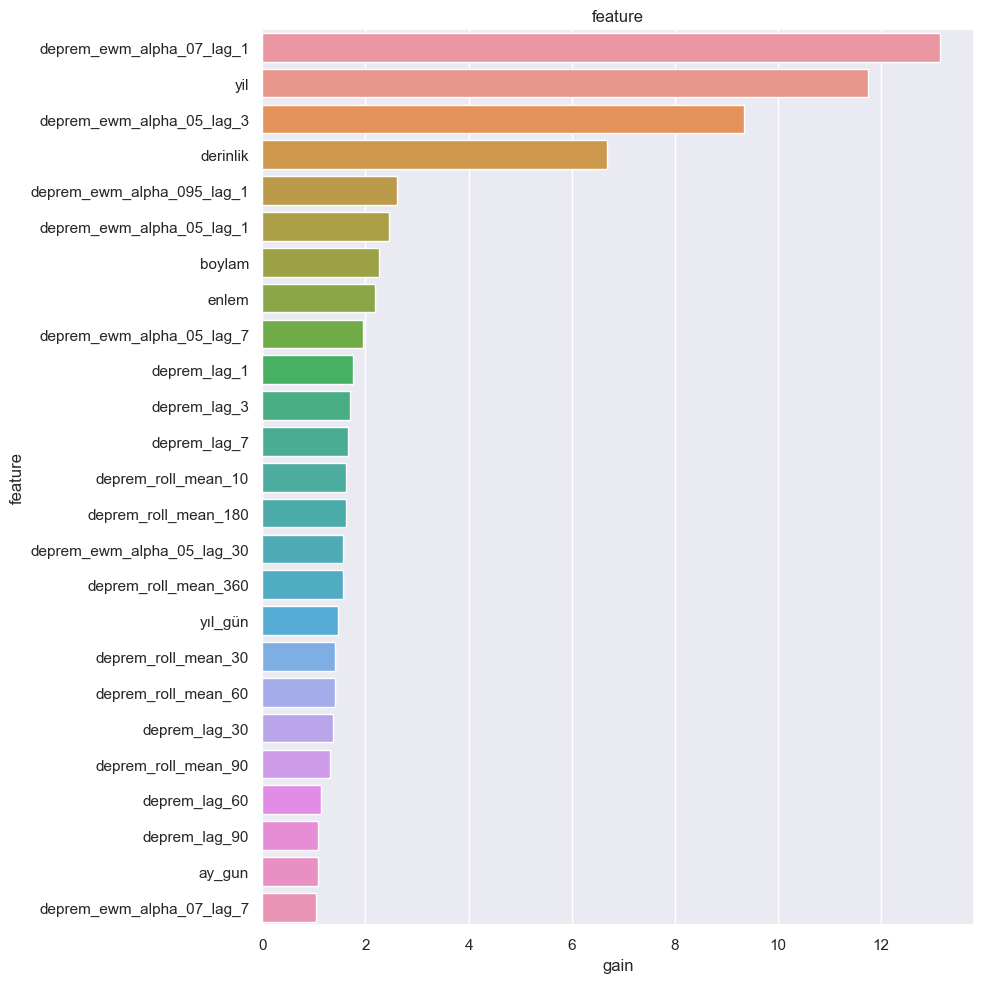

,feature,split,gain
52,deprem_ewm_alpha_07_lag_1,19082,13.149613
4,yil,41291,11.755039
61,deprem_ewm_alpha_05_lag_3,16580,9.347243
2,derinlik,58996,6.687196
28,deprem_ewm_alpha_095_lag_1,23642,2.620047
60,deprem_ewm_alpha_05_lag_1,22495,2.460619
1,boylam,47064,2.264114
0,enlem,55054,2.189028
62,deprem_ewm_alpha_05_lag_7,12593,1.946038
14,deprem_lag_1,49468,1.758290


In [141]:
plot_lgb_importances(model, num=50, plot=True)

In [142]:
model.best_iteration

0

In [143]:
model.params

{'boosting_type': 'gbdt',
 'learning_rate': 0.19986850305793402,
 'subsample': 0.9778880064060288,
 'subsample_freq': 5,
 'feature_fraction': 0.6153367760626559,
 'min_child_samples': 17,
 'min_data_in_leaf': 67,
 'objective': None,
 'num_iterations': 30000}

## Final Model

Bütün veri ile modeli fit edelim.

In [146]:
########################
# Final Model
########################

train = df.loc[~df.xm.isna()]
Y_train = train['xm']
X_train = train[cols]


test = df.loc[df.xm.isna()]
X_test = test[cols]

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(best_trial.params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round =30000,
                  # early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  # verbose_eval=1000
                  )

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15130
[LightGBM] [Info] Number of data points in the train set: 19903, number of used features: 117
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.600633


3.1705218227759475e-06

In [148]:
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

In [149]:
test_preds

array([1.6053776 , 1.58616927, 1.61700223, ..., 1.663852  , 1.63774361,
       1.62535518])

In [150]:
test_preds.min(), test_preds.max()

(1.4930813966762149, 1.8078925893012339)

In [151]:
np.expm1(test_preds.max())

5.097583769209037

In [153]:
np.argmax(test_preds)

953

In [154]:
df2_["xm"] = np.expm1(test_preds)

In [155]:
df2_.head()

,temizlenmis_yer,derinlik,depremin_olus_zamani,enlem,boylam,xm
0,AKDENIZ,26.014984,2023-09-10,36.0000,36.0000,3.979740
1,GONCEK-EMET KUTAHYA,25.000000,2023-09-10,39.2800,39.2800,3.885000
2,SANDIKLI-GEDIZ KUTAHYA,38.500000,2023-09-10,38.9200,38.9200,4.037965
3,SURiYE,6.750000,2023-09-10,35.1165,35.1165,3.910436
4,ARDAHAN,14.082051,2023-09-10,40.7580,40.7580,3.981144


In [156]:
df2_.to_excel("output2.xlsx")

In [144]:
########################
# Final Model
########################

train = df.loc[~df.xm.isna()]
Y_train = train['xm']
X_train = train[cols]


test = df.loc[df.xm.isna()]
X_test = test[cols]

lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 10,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": 20000}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(best_trial.params, lgbtrain_all, num_boost_round=model.best_iteration)



test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)


ValueError: num_boost_round must be greater than 0. Got 0.

In [102]:
test_preds

array([1.60140779, 1.6000677 , 1.59361551, ..., 1.62386439, 1.59012861,
       1.59012861])

In [103]:
len(test_preds)

2208

In [105]:
df2_.head()

,temizlenmis_yer,derinlik,depremin_olus_zamani,enlem,boylam,xm
0,AKDENIZ,26.014984,2023-09-10,36.0000,36.0000,NaN
1,GONCEK-EMET KUTAHYA,25.000000,2023-09-10,39.2800,39.2800,NaN
2,SANDIKLI-GEDIZ KUTAHYA,38.500000,2023-09-10,38.9200,38.9200,NaN
3,SURiYE,6.750000,2023-09-10,35.1165,35.1165,NaN
4,ARDAHAN,14.082051,2023-09-10,40.7580,40.7580,NaN


In [109]:
df2_["xm"] = np.expm1(test_preds)

In [110]:
df2_.head()

,temizlenmis_yer,derinlik,depremin_olus_zamani,enlem,boylam,xm
0,AKDENIZ,26.014984,2023-09-10,36.0000,36.0000,3.960010
1,GONCEK-EMET KUTAHYA,25.000000,2023-09-10,39.2800,39.2800,3.953368
2,SANDIKLI-GEDIZ KUTAHYA,38.500000,2023-09-10,38.9200,38.9200,3.921511
3,SURiYE,6.750000,2023-09-10,35.1165,35.1165,4.033025
4,ARDAHAN,14.082051,2023-09-10,40.7580,40.7580,3.922978


In [111]:
df2_.to_excel("output.xlsx")

In [112]:
test_preds.max()

1.6609844455640068

In [113]:
np.expm1(test_preds.max())

4.264490898999964

## Inspect_df ile İnceleme

In [175]:
inspect_df = pd.read_csv("dataset.csv", encoding="unicode-escape", sep=",",on_bad_lines="skip",index_col="Unnamed: 0")

In [176]:
inspect_df.head()

,No,Deprem Kodu,Olus tarihi,Olus zamani,Enlem,Boylam,Derinlik,xM,MD,ML,Mw,Ms,Mb,Tip,Yer
0,1,20230430130127,2023.04.30,13:01:27.69,38.3392,37.7633,8.7,4.3,0.0,4.3,4.3,0.0,0.0,Ke,KEPEZ-AKCADAG (MALATYA) [East 1.7 km]
1,2,20230430040253,2023.04.30,04:02:53.49,40.8077,31.0708,3.7,3.5,0.0,3.5,3.4,0.0,0.0,Ke,PASAKONAGI- (DUZCE) [South West 0.9 km]
2,3,20230430025122,2023.04.30,02:51:22.15,35.6422,34.0252,22.4,3.5,0.0,3.5,3.5,0.0,0.0,Ke,AKDENIZ
3,4,20230429194832,2023.04.29,19:48:32.87,37.8623,36.2185,5.0,4.0,0.0,3.9,4.0,0.0,0.0,Ke,KARAKUYU-SAIMBEYLI (ADANA) [East 1.4 km]
4,5,20230429175829,2023.04.29,17:58:29.20,38.0220,36.4457,5.0,3.7,0.0,3.7,3.4,0.0,0.0,Ke,YIRICEK-GOKSUN (KAHRAMANMARAS) [North West 2....


In [177]:
inspect_df.columns = [col.lower() for col in inspect_df.columns]

In [178]:
inspect_df["olus tarihi"] = inspect_df["olus tarihi"].astype(str)
inspect_df["olus zamani"] = inspect_df["olus zamani"].astype(str)
# tip değişkeni 2 sınıf ve SM sınıfından sadece 2 gözlem var. O yüzden dropluyorum bu kolonu.
inspect_df["depremin_olus_zamani"] = inspect_df["olus tarihi"] + " " + inspect_df["olus zamani"]
inspect_df.drop(["olus tarihi", "olus zamani", "tip"], axis = 1, inplace = True)
inspect_df["depremin_olus_zamani"] = pd.to_datetime(inspect_df["depremin_olus_zamani"])
inspect_df.drop_duplicates(subset=["deprem kodu"],inplace = True)

In [179]:
# ============================================

# Türkçe karakterleri İngilizce karakterlere dönüştüren bir çeviri sözlüğü oluşturalım
turkce_ingilizce_ceviri = {
    'ç': 'c',
    'ğ': 'g',
    'ı': 'i',
    'ö': 'o',
    'ş': 's',
    'ü': 'u',
    'Ç': 'C',
    'Ğ': 'G',
    'İ': 'I',
    'Ö': 'O',
    'Ş': 'S',
    'Ü': 'U'
}


inspect_df["yer"] = inspect_df["yer"].apply(lambda yer: yer.translate(str.maketrans(turkce_ingilizce_ceviri)))
# Şehir isimlerini çekmek için düzenli ifade kullanalım

def extract_cities(dataframe,column):
  sadece_sehirler = []
  for yer in dataframe[column]:
      eslesme = re.search(r'\((.*?)\)', yer)  # Parantez içindekileri kontrol et
      if eslesme:
          sadece_sehirler.append(eslesme.group(1))  # Parantez içindeki değeri ekle
      else:
          sadece_sehirler.append(yer)  # Parantez içinde değer yoksa doğrudan ekle
  return sadece_sehirler

inspect_df["temizlenmis_yer"] = extract_cities(inspect_df,"yer")

In [180]:
inspect_df.head()

,no,deprem kodu,enlem,boylam,derinlik,xm,md,ml,mw,ms,mb,yer,depremin_olus_zamani,temizlenmis_yer
0,1,20230430130127,38.3392,37.7633,8.7,4.3,0.0,4.3,4.3,0.0,0.0,KEPEZ-AKCADAG (MALATYA) [East 1.7 km],2023-04-30 13:01:27.690,MALATYA
1,2,20230430040253,40.8077,31.0708,3.7,3.5,0.0,3.5,3.4,0.0,0.0,PASAKONAGI- (DUZCE) [South West 0.9 km],2023-04-30 04:02:53.490,DUZCE
2,3,20230430025122,35.6422,34.0252,22.4,3.5,0.0,3.5,3.5,0.0,0.0,AKDENIZ,2023-04-30 02:51:22.150,AKDENIZ
3,4,20230429194832,37.8623,36.2185,5.0,4.0,0.0,3.9,4.0,0.0,0.0,KARAKUYU-SAIMBEYLI (ADANA) [East 1.4 km],2023-04-29 19:48:32.870,ADANA
4,5,20230429175829,38.0220,36.4457,5.0,3.7,0.0,3.7,3.4,0.0,0.0,YIRICEK-GOKSUN (KAHRAMANMARAS) [North West 2....,2023-04-29 17:58:29.200,KAHRAMANMARAS


In [182]:
# Yerin neresi olduğu belli olmadığı için çıkartıyorum.
# df = df[~(df["temizlenmis_yer"] == "#NAME?")]

In [194]:
# Köşeli parantezleri atıyoruz. Böylelikle o şehir/alandaki depremlere odaklanmış oluyoruz.
inspect_df["temizlenmis_yer"] = inspect_df["temizlenmis_yer"].apply(lambda yer: re.sub(r'\[.*?\]', '', yer))
inspect_df = inspect_df[~(inspect_df["temizlenmis_yer"] == "#NAME?")]
inspect_df["ay"] = inspect_df["depremin_olus_zamani"].dt.month
inspect_df["yil"] = inspect_df["depremin_olus_zamani"].dt.year
inspect_df["ay_gun"] = inspect_df["depremin_olus_zamani"].dt.day
inspect_df["hafta_gun"] = inspect_df["depremin_olus_zamani"].dt.dayofweek
inspect_df["saat"] =  inspect_df["depremin_olus_zamani"].dt.hour
inspect_df["aksam"] = ((inspect_df['saat'] >= 18) & (inspect_df['saat'] <= 23)) | ((inspect_df['saat'] >= 0) & (inspect_df['saat'] <= 5))
inspect_df['yıl_gün'] = inspect_df["depremin_olus_zamani"].dt.dayofyear
inspect_df['yıl_hafta'] = inspect_df["depremin_olus_zamani"].dt.weekofyear
inspect_df["ay_basi"] = inspect_df["depremin_olus_zamani"].dt.is_month_start.astype(int)
inspect_df["ay_sonu"] = inspect_df["depremin_olus_zamani"].dt.is_month_end.astype(int)

C:\Users\oftomurcuk\AppData\Local\Temp\ipykernel_17016\3084757473.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  inspect_df['yıl_hafta'] = inspect_df["depremin_olus_zamani"].dt.weekofyear


In [184]:
inspect_df.head()

,no,deprem kodu,enlem,boylam,derinlik,xm,md,ml,mw,ms,...,ay,yil,ay_gun,hafta_gun,saat,aksam,yıl_gün,yıl_hafta,ay_basi,ay_sonu
0,1,20230430130127,38.3392,37.7633,8.7,4.3,0.0,4.3,4.3,0.0,...,4,2023,30,6,13,False,120,17,0,1
1,2,20230430040253,40.8077,31.0708,3.7,3.5,0.0,3.5,3.4,0.0,...,4,2023,30,6,4,True,120,17,0,1
2,3,20230430025122,35.6422,34.0252,22.4,3.5,0.0,3.5,3.5,0.0,...,4,2023,30,6,2,True,120,17,0,1
3,4,20230429194832,37.8623,36.2185,5.0,4.0,0.0,3.9,4.0,0.0,...,4,2023,29,5,19,True,119,17,0,0
4,5,20230429175829,38.0220,36.4457,5.0,3.7,0.0,3.7,3.4,0.0,...,4,2023,29,5,17,False,119,17,0,0


In [192]:
inspect_df.columns

Index(['no', 'deprem kodu', 'enlem', 'boylam', 'derinlik', 'xm', 'md', 'ml',
       'mw', 'ms', 'mb', 'yer', 'depremin_olus_zamani', 'temizlenmis_yer',
       'ay', 'yil', 'ay_gun', 'hafta_gun', 'saat', 'aksam', 'yıl_gün',
       'yıl_hafta', 'ay_basi', 'ay_sonu'],
      dtype='object')

In [185]:
inspect_df["ay"].value_counts()

2     2539
10    1778
3     1776
5     1728
4     1670
1     1630
11    1570
6     1549
7     1514
8     1508
9     1367
12    1274
Name: ay, dtype: int64

In [187]:
inspect_df["yıl_gün"].value_counts()

37     427
38     231
39     141
40     134
296    129
304    120
25      98
41      98
202     98
305     97
88      96
297     96
87      95
51      95
299     94
317     90
54      87
163     85
298     84
121     83
55      83
42      81
316     80
22      80
43      79
73      77
144     76
301     76
220     75
32      74
107     74
311     73
24      72
213     72
23      71
201     71
30      71
135     71
91      71
124     71
306     70
140     70
89      70
45      69
46      69
82      68
109     68
114     68
35      67
247     67
85      66
49      66
61      66
290     66
166     66
117     66
34      66
71      65
307     65
26      65
318     65
178     65
106     65
148     65
139     64
56      64
13      64
118     63
116     63
28      63
108     63
86      63
161     63
53      63
111     63
206     62
77      62
122     62
76      62
227     62
128     62
232     61
167     61
83      61
203     61
270     60
191     60
123     60
79      60
59      60
303     60

In [188]:
inspect_df["yıl_hafta"].value_counts()

6     1208
43     504
44     494
13     492
4      477
8      474
42     446
5      445
29     440
18     427
16     427
17     424
45     417
7      407
19     400
46     397
14     395
30     391
9      391
24     391
20     388
33     383
12     373
11     371
2      366
21     366
23     365
25     363
39     360
10     356
32     353
26     346
15     343
36     340
22     326
49     321
27     318
47     316
31     312
34     311
35     303
3      298
51     295
40     293
38     292
37     284
52     281
41     275
48     274
28     273
1      273
50     261
53      77
Name: yıl_hafta, dtype: int64

In [196]:
inspect_df["aksam"].value_counts()

True     10497
False     9406
Name: aksam, dtype: int64

In [195]:
inspect_df["saat"].value_counts()

23    917
0     910
3     895
1     893
22    887
20    881
21    878
2     874
18    851
4     847
14    840
19    837
16    831
5     827
17    819
10    816
11    811
12    798
13    794
8     757
15    754
7     736
9     727
6     723
Name: saat, dtype: int64

In [193]:
inspect_df["temizlenmis_yer"].value_counts()

AKDENIZ                                4605
EGE DENIZI                             1527
VAN                                     914
KAHRAMANMARAS                           756
MUGLA                                   745
MANISA                                  595
MALATYA                                 531
DENIZLI                                 491
IZMIR                                   472
ELAZIG                                  407
BINGOL                                  394
BALIKESIR                               379
BURDUR                                  363
ERZURUM                                 357
AFYONKARAHISAR                          320
ANTALYA                                 277
CANAKKALE                               274
ANKARA                                  231
MARMARA DENIZI                          225
HATAY                                   223
ADIYAMAN                                219
ADANA                                   201
BURSA                           

In [199]:
after2020 = inspect_df[inspect_df["yil"]>2019]

In [200]:
after2020["ay"].value_counts()

2     1374
1      290
3      278
4      234
10     231
11     135
8      128
9      123
6      119
7      116
12      96
5       87
Name: ay, dtype: int64

In [201]:
after2020["yıl_gün"].value_counts()

37     391
38     179
39     102
304     92
40      80
305     51
41      51
43      51
54      48
42      48
51      41
24      37
44      33
25      33
55      30
49      30
46      28
22      28
213     28
45      25
32      25
30      23
47      23
50      22
56      21
59      19
48      19
28      19
53      17
52      17
79      16
35      16
33      16
58      15
65      15
31      14
77      14
78      14
23      14
306     14
57      14
307     13
66      13
178     13
71      13
62      13
270     13
75      13
100     12
26      12
68      12
82      12
97      12
115     12
60      11
110     11
29      11
107     11
87      11
103     11
203     11
72      11
73      11
310     11
108     10
27      10
98      10
191     10
116     10
64      10
101     10
18      10
151      9
113      9
112      9
308      9
218      9
286      9
20       8
99       8
252      8
63       8
274      8
291      8
11       8
361      8
7        8
93       8
215      8
91       8
360      8

In [202]:
after2020["aksam"].value_counts()

True     1632
False    1579
Name: aksam, dtype: int64

In [206]:
after2020[(after2020["yil"] == 2023) & (after2020["ay"]==2)].tail()

,no,deprem kodu,enlem,boylam,derinlik,xm,md,ml,mw,ms,...,ay,yil,ay_gun,hafta_gun,saat,aksam,yıl_gün,yıl_hafta,ay_basi,ay_sonu
1427,1428,20230204060339,40.7682,34.9722,5.0,4.0,0.0,4.0,3.9,0.0,...,2,2023,4,5,6,False,35,5,0,0
1428,1429,20230203110508,37.1995,36.4118,5.3,4.2,0.0,4.2,4.1,0.0,...,2,2023,3,4,11,False,34,5,0,0
1429,1430,20230203045948,40.6887,36.7085,4.9,3.7,0.0,3.7,3.7,0.0,...,2,2023,3,4,4,True,34,5,0,0
1430,1431,20230201182856,38.0650,30.0827,3.6,3.6,0.0,3.5,3.6,0.0,...,2,2023,1,2,18,True,32,5,1,0
1431,1432,20230201075620,38.6668,44.8080,5.0,3.5,0.0,3.4,3.5,0.0,...,2,2023,1,2,7,False,32,5,1,0


In [204]:
after2020.head()

,no,deprem kodu,enlem,boylam,derinlik,xm,md,ml,mw,ms,...,ay,yil,ay_gun,hafta_gun,saat,aksam,yıl_gün,yıl_hafta,ay_basi,ay_sonu
0,1,20230430130127,38.3392,37.7633,8.7,4.3,0.0,4.3,4.3,0.0,...,4,2023,30,6,13,False,120,17,0,1
1,2,20230430040253,40.8077,31.0708,3.7,3.5,0.0,3.5,3.4,0.0,...,4,2023,30,6,4,True,120,17,0,1
2,3,20230430025122,35.6422,34.0252,22.4,3.5,0.0,3.5,3.5,0.0,...,4,2023,30,6,2,True,120,17,0,1
3,4,20230429194832,37.8623,36.2185,5.0,4.0,0.0,3.9,4.0,0.0,...,4,2023,29,5,19,True,119,17,0,0
4,5,20230429175829,38.0220,36.4457,5.0,3.7,0.0,3.7,3.4,0.0,...,4,2023,29,5,17,False,119,17,0,0


In [218]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [226]:
nump_deneme = np.array(inspect_df.loc[inspect_df["temizlenmis_yer"]=="AKDENIZ","enlem"])

In [230]:
nump_deneme.mean()

36.00945211726384

In [236]:
inspect_df["enlem_boylam"] = inspect_df["enlem"].astype(str)+"__"+inspect_df["boylam"].astype(str)

In [237]:
inspect_df["enlem_boylam"].head()

0    38.3392__37.7633
1    40.8077__31.0708
2    35.6422__34.0252
3    37.8623__36.2185
4     38.022__36.4457
Name: enlem_boylam, dtype: object

In [239]:
len(inspect_df["enlem_boylam"].value_counts())

19162

## Joblib

In [240]:
!pip install joblib

Defaulting to user installation because normal site-packages is not writeable


In [242]:
import joblib

In [243]:
joblib.dump(final_model, "final_model.pkl")

['final_model.pkl']

## Validation test

In [281]:
# Y_val = val['xm']
# X_val = val[cols]

In [282]:
Y_val

1478   1.56862
1477   1.54756
1476   1.54756
1475   1.82455
1474   1.54756
         ...  
100    1.66771
99     1.52606
98     1.52606
97     1.52606
96     1.72277
Name: xm, Length: 1383, dtype: float64

In [292]:
df.loc[(df["depremin_olus_zamani"] >= "2023-01-01") & (df["depremin_olus_zamani"] < "2023-04-01"), :]

,no,deprem kodu,enlem,boylam,derinlik,xm,yer,depremin_olus_zamani,temizlenmis_yer
96,97,20230331105656,36.99080,36.59980,10.20000,4.60000,DEGIRMENCIK-ISLAHIYE (GAZIANTEP) [South West ...,2023-03-31 10:56:56.640,GAZIANTEP
97,98,20230330232715,38.16380,37.91070,5.00000,3.60000,POLATDERESI-DOGANSEHIR (MALATYA) [North West ...,2023-03-30 23:27:15.970,MALATYA
98,99,20230330061401,38.34880,38.20480,5.00000,3.60000,TOPSOGUT- (MALATYA) [South West 4.1 km],2023-03-30 06:14:01.110,MALATYA
99,100,20230330012125,35.95570,36.25680,5.80000,3.60000,ERBASI-ALTINOZU (HATAY) [South East 2.0 km],2023-03-30 01:21:25.420,HATAY
100,101,20230329214419,37.86030,36.62100,5.00000,4.30000,DONGEL- (KAHRAMANMARAS) [North West 1.7 km],2023-03-29 21:44:19.540,KAHRAMANMARAS
...,...,...,...,...,...,...,...,...,...
1474,1475,20230107020153,39.37900,26.26020,10.00000,3.70000,MIDILLI ADASI (EGE DENIZI),2023-01-07 02:01:53.230,EGE DENIZI
1475,1476,20230107015257,39.37200,26.27730,11.10000,5.20000,MIDILLI ADASI (EGE DENIZI),2023-01-07 01:52:57.770,EGE DENIZI
1476,1477,20230106180252,37.88730,27.26820,5.50000,3.70000,KUSADASI (AYDIN) [North East 3.3 km],2023-01-06 18:02:52.960,AYDIN
1477,1478,20230106103218,37.88530,27.26600,4.10000,3.70000,KUSADASI (AYDIN) [North 3.1 km],2023-01-06 10:32:18.440,AYDIN


In [287]:
Y_val.shape

(1383,)

In [288]:
y_pred_val.shape

(1383,)

In [289]:
y_pred_val

array([1.56861591, 1.54756248, 1.54756248, ..., 1.52605629, 1.52605629,
       1.72276664])

In [294]:
val.to_excel("kontrol.xlsx")

In [295]:
deneme_val = X_val.copy()

In [296]:
deneme_val["xm"]= y_pred_val

In [297]:
deneme_val.to_excel("kontrol2.xlsx")